In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import math
import seaborn as sns
import plotly.graph_objects as go


In [2]:
#Reading data
#Spanish data from spanish health ministry, all hisotrical series
data = pd.read_csv(r"https://covid19.isciii.es/resources/serie_historica_acumulados.csv",skipfooter=3,error_bad_lines=False,encoding = 'ANSI')

data.columns = ['CCAA Codigo ISO','Fecha','Casos Old','Casos','TestAc','Hospitalizados','UCI','Fallecidos','Recuperados']
#World data from Johns Hopkins University (github)
#Confirmed cases
data_jh_conf = pd.read_csv(r"https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv", 
                           error_bad_lines=False,encoding = 'ANSI')

#Confirmed deaths
data_jh_muertos = pd.read_csv(r"https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv", 
                           error_bad_lines=False,encoding = 'ANSI')

#Confirmed recovered
data_jh_recuperados = pd.read_csv(r"https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv", 
                           error_bad_lines=False,encoding = 'ANSI')

#Cataluña data
data_cat = pd.read_csv(r"https://analisi.transparenciacatalunya.cat/api/views/jj6z-iyrp/rows.csv?accessType=DOWNLOAD&bom=true&format=true&delimiter=%3B&sorting=true", sep=";",encoding = 'utf-8')

#Spanish data from Madrid
data_madrid = pd.read_csv(r"https://datos.comunidad.madrid/catalogo/dataset/7da43feb-8d4d-47e0-abd5-3d022d29d09e/resource/b2a3a3f9-1f82-42c2-89c7-cbd3ef801412/download/covid19_tia_muni_y_distritos.csv", sep=";",encoding = 'ANSI')

#datos de renta por municipios
data_renta_municipios = pd.read_csv(r"C:\Users\guillermo.arguello\Documents\Covid Analisys\renta_municipios.csv", sep="|",encoding = 'ANSI')

#datos población paises

data_poblacion = pd.read_excel('https://population.un.org/wpp/Download/Files/1_Indicators%20(Standard)/EXCEL_FILES/1_Population/WPP2019_POP_F01_1_TOTAL_POPULATION_BOTH_SEXES.xlsx',
                                    sheet_name="ESTIMATES",skiprows= 16)

data_poblacion = data_poblacion[["Region, subregion, country or area *","2020"]]

data["Casos"] =  np.where(data["Casos"].isna(), data["Casos Old"],data["Casos"])


In [3]:
#Transpose Johns Hopkins Data

data_jh_conf = data_jh_conf.melt(['Province/State', 'Country/Region',"Lat","Long"], var_name='Fecha', value_name='Casos')
data_jh_muertos = data_jh_muertos.melt(['Province/State', 'Country/Region',"Lat","Long"], var_name='Fecha', value_name='Fallecidos')
data_jh_recuperados = data_jh_recuperados.melt(['Province/State', 'Country/Region',"Lat","Long"], var_name='Fecha', value_name='Recuperados')

#Join all data in one dataframe
data_jh = pd.merge(data_jh_conf, data_jh_muertos, left_on=['Province/State','Country/Region','Fecha','Lat','Long'], 
                   right_on = ['Province/State','Country/Region','Fecha','Lat','Long'])

data_jh = pd.merge(data_jh, data_jh_recuperados, how= 'left',left_on=['Province/State','Country/Region','Fecha','Lat','Long'], 
                   right_on = ['Province/State','Country/Region','Fecha','Lat','Long'])

#Removing Province/State, Lat and long data, we won´t use it (it could be usefull for geographical plots)

data_jh = data_jh.drop(["Province/State","Lat","Long"], axis=1)


In [4]:
data_jh = data_jh.dropna()
data_jh = data_jh.groupby(['Fecha','Country/Region'], as_index=False).sum()
data_jh = data_jh.sort_values(by=['Fecha'])
data_jh["Fecha2"] = pd.to_datetime(data_jh["Fecha"], format="%m/%d/%y").dt.strftime('%Y%m%d').astype(int).sort_values(ascending=False)
data_jh["Fecha"] = pd.to_datetime(data_jh["Fecha"], format="%m/%d/%y")
data_jh["Casos"] = pd.to_numeric(data_jh["Casos"])
data_jh["Fallecidos"] = pd.to_numeric(data_jh["Fallecidos"])
data_jh["Recuperados"] = pd.to_numeric(data_jh["Recuperados"])
data_jh["Country/Region"] = data_jh["Country/Region"].astype(str)

data_jh = data_jh.set_index('Fecha2')
data_jh = data_jh.sort_index()
data_jh = data_jh.reset_index()

data_jh['Diferencia casos dia anterior'] = data_jh.groupby('Country/Region', as_index=True).diff(1)["Casos"]
data_jh['Diferencia fallecidos dia anterior'] = data_jh.groupby('Country/Region', as_index=True).diff(1)["Fallecidos"]
data_jh['Diferencia recuperados dia anterior'] = data_jh.groupby('Country/Region', as_index=True).diff(1)["Recuperados"]
data_jh = data_jh.fillna(0)
data_jh = data_jh.drop(["Fecha2"], axis=1)

data_jh = pd.merge(data_jh, data_poblacion, how= 'left',left_on=['Country/Region'], 
                   right_on = ['Region, subregion, country or area *'])

data_jh = data_jh.set_index('Fecha')
data_jh["Incremento porcentual de casos respecto al total"]= data_jh["Diferencia casos dia anterior"]/data_jh["Casos"]*100
data_jh["Incremento porcentual de fallecidos respecto al total"]= data_jh["Diferencia fallecidos dia anterior"]/data_jh["Fallecidos"]*100

data_jh = data_jh.rename(columns={"2020": "2020 Population"})

data_jh["Fallecidos por millón habitantes"]= data_jh["Fallecidos"]/(data_jh["2020 Population"]/1000)


data_sem_jh = data_jh.groupby(['Country/Region'], as_index=True).rolling(7, center=False).mean()

In [5]:
data = data.fillna(0)
data.drop(data[ data['Fecha'] == 0 ].index , inplace=True)
data["Fecha"] = pd.to_datetime(data["Fecha"], format="%d/%m/%Y").sort_values()
data['Diferencia casos dia anterior'] = data.groupby('CCAA Codigo ISO', as_index=True).diff(1)["Casos"]
data['Diferencia hospitalizados dia anterior'] = data.groupby('CCAA Codigo ISO', as_index=True).diff(1)["Hospitalizados"]
data['Diferencia UCI dia anterior'] = data.groupby('CCAA Codigo ISO', as_index=True).diff(1)["UCI"]
data['Diferencia fallecidos dia anterior'] = data.groupby('CCAA Codigo ISO', as_index=True).diff(1)["Fallecidos"]
data['Diferencia recuperados dia anterior'] = data.groupby('CCAA Codigo ISO', as_index=True).diff(1)["Recuperados"]

data = data.fillna(0)
data_es = data.groupby('Fecha', as_index=False).sum()
data_es = data_es.set_index('Fecha')
data_es = data_es[data_es["Fallecidos"] > 10]
data_es["Incremento porcentual de casos respecto al total"]= (data_es["Diferencia casos dia anterior"]/data_es["Casos"]*100).round(3)
data_es["Incremento porcentual de fallecidos respecto al total"]= (data_es["Diferencia fallecidos dia anterior"]/data_es["Fallecidos"]*100).round(3)

data_sem = data_es.rolling(7, center=False).mean()


In [6]:
data_cat["Data"] = pd.to_datetime(data_cat["TipusCasData"], format="%d/%m/%Y").sort_values()
data_cat_gropued = data_cat.groupby('Data',as_index = False).sum().sort_values('Data',ascending=True)
data_cat_gropued = data_cat_gropued[data_cat_gropued["Data"] > "2020-03-01"]
data_cat_gropued = data_cat_gropued.set_index('Data')
data_cat_gropued_resultado = data_cat.groupby(['Data',"TipusCasDescripcio"],as_index = False).sum().sort_values('Data',ascending=True)
data_cat_gropued_resultado = data_cat_gropued_resultado[data_cat_gropued_resultado["Data"] > "2020-03-01"]
data_cat_gropued_resultado = data_cat_gropued_resultado.set_index('Data')

In [7]:
#Procasamiento datos Madrid
data_madrid = data_madrid[["municipio_distrito","fecha_informe","casos_confirmados_totales","tasa_incidencia_acumulada_total"]]
data_madrid = data_madrid.dropna()
data_madrid["municipio_distrito"]= data_madrid["municipio_distrito"].str.strip()
data_renta_municipios["MUNICIPIO"]= data_renta_municipios["MUNICIPIO"].str.strip()

data_renta_municipios = data_renta_municipios[["MUNICIPIO","RENTA DISPONIBLE MEDIA","NUMERO HABITANTES"]]
data_mad = pd.merge(data_madrid, data_renta_municipios, how= 'left',left_on=['municipio_distrito'], 
                   right_on = ['MUNICIPIO'])

data_mad["tasa_incidencia_acumulada_total"] = data_mad["tasa_incidencia_acumulada_total"].str.replace(",",".")
data_mad["tasa_incidencia_acumulada_total"] = pd.to_numeric(data_mad["tasa_incidencia_acumulada_total"])
data_mad["NUMERO HABITANTES"] = data_mad["NUMERO HABITANTES"].str.replace(".","")
data_mad["NUMERO HABITANTES"] = pd.to_numeric(data_mad["NUMERO HABITANTES"])


#data_mad = data_mad.dropna(subset = ["RENTA BRUTA MEDIA"])
#data_mad = data_mad.dropna()


data_mad.loc[data_mad["RENTA DISPONIBLE MEDIA"] < data_mad["RENTA DISPONIBLE MEDIA"].median()*0.85 , "Renta Categorical"] = 'Renta Baja'

data_mad.loc[(data_mad["RENTA DISPONIBLE MEDIA"] >= data_mad["RENTA DISPONIBLE MEDIA"].median()*0.85) & 
         (data_mad["RENTA DISPONIBLE MEDIA"] < data_mad["RENTA DISPONIBLE MEDIA"].median()*1), "Renta Categorical"] = 'Renta Media-Baja'

data_mad.loc[(data_mad["RENTA DISPONIBLE MEDIA"] >= data_mad["RENTA DISPONIBLE MEDIA"].median()*1) & 
         (data_mad["RENTA DISPONIBLE MEDIA"] < data_mad["RENTA DISPONIBLE MEDIA"].median()*1.25), "Renta Categorical"] = 'Renta Media-Media'

data_mad.loc[(data_mad["RENTA DISPONIBLE MEDIA"] >= data_mad["RENTA DISPONIBLE MEDIA"].median()*1.25) & 
         (data_mad["RENTA DISPONIBLE MEDIA"] < data_mad["RENTA DISPONIBLE MEDIA"].median()*1.5), "Renta Categorical"] = 'Renta Media-Alta'

data_mad.loc[data_mad["RENTA DISPONIBLE MEDIA"] > data_mad["RENTA DISPONIBLE MEDIA"].median()*1.5, "Renta Categorical"] = 'Renta Alta'


data_mad = data_mad[data_mad["NUMERO HABITANTES"] > 1000] 
data_mad = data_mad[data_mad["casos_confirmados_totales"] > 20] 


In [8]:
data_es.to_csv(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\data_es_historical_series.csv')
data_jh.to_csv(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\john_hopkins_university_historical_series.csv')
data_cat_gropued.to_csv(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\data_catalunya.csv')
data_mad.to_csv(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\data_madrid.csv')


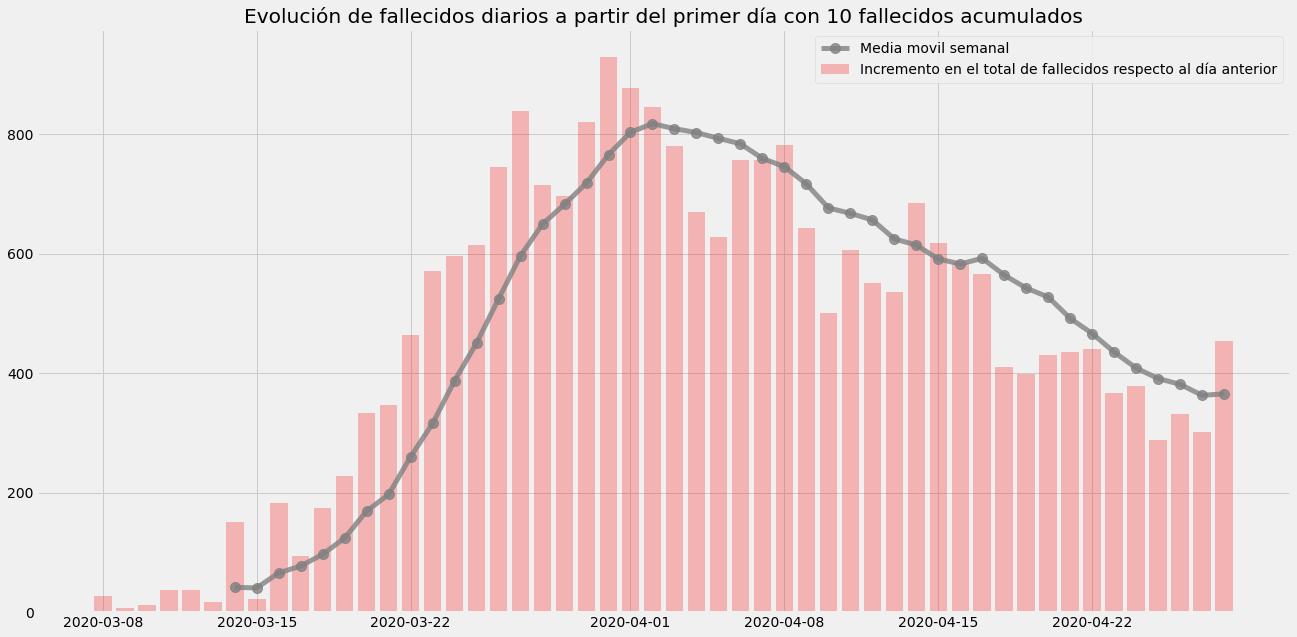

In [9]:
# Let's build our plot
# Set up plot 
fig, ax1 = plt.subplots(figsize=(20,10))
ax2 = ax1 # set up the 2nd axis

#Next lines plot the line of the plot
ax1.plot(data_sem['Diferencia fallecidos dia anterior'],alpha=1.8,color='grey',
         label='Media movil semanal',marker='o', markersize=10,linewidth=5)

#Next lines plot the bar chat part of the plot
ax2.bar(data_es.index, data_es["Diferencia fallecidos dia anterior"],width=0.8, alpha=0.25, color='red',
       label='Incremento en el total de fallecidos respecto al día anterior')

ax1.grid(b=True) #Turn on grid

#set up the title and legend
ax1.set_title('Evolución de fallecidos diarios a partir del primer día con 10 fallecidos acumulados')
ax1.legend()
plt.savefig(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\imagenes\fallecidos.png');



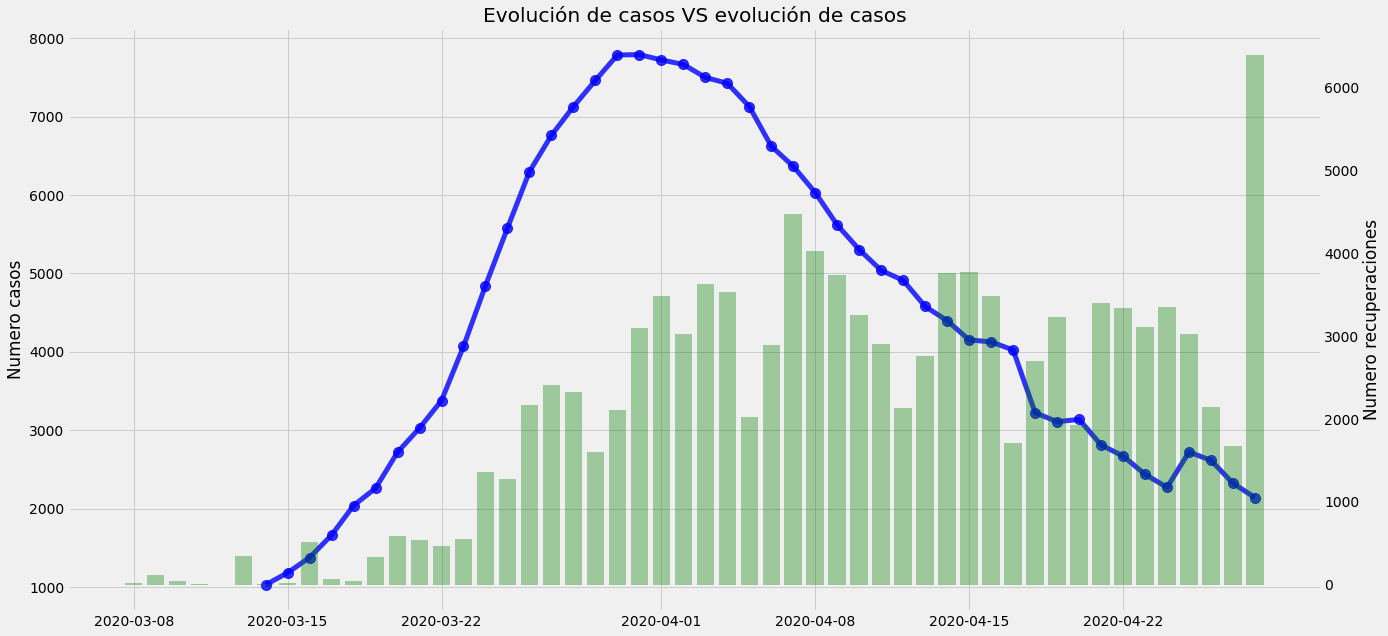

In [10]:
# Let's build our plot
# Set up plot 

fig, ax1 = plt.subplots(figsize=(20,10))
ax2 = ax1.twinx()  # set up the 2nd axis

#Next lines plot the line of the plot

ax1.plot(data_sem['Diferencia casos dia anterior'],alpha=0.8,color='blue',
         label='Incremento en el total de casos respecto al día anterior',marker='o', markersize=10,linewidth=5)

#Next lines plot the bar chat part of the plot
ax2.bar(data_sem.index, data_es["Diferencia recuperados dia anterior"],width=0.8, alpha=0.35, color='green',
       label='Incremento en el total de recuperados respecto al día anterior')


ax2.grid(b=False) # turn off grid #2

ax1.set_title('Evolución de casos VS evolución de casos')
ax1.set_ylabel('Numero casos')
ax2.set_ylabel('Numero recuperaciones');



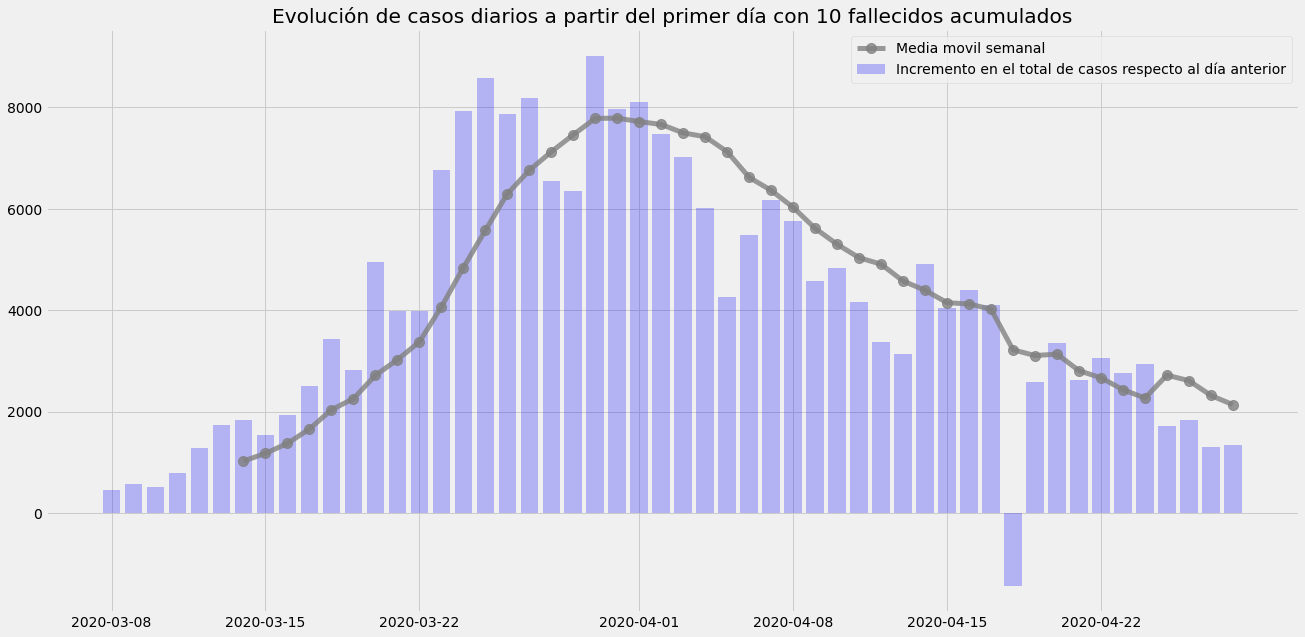

In [11]:
# Let's build our plot
# Set up plot 
fig, ax1 = plt.subplots(figsize=(20,10))
ax2 = ax1 # set up the 2nd axis

#Next lines plot the line of the plot
ax1.plot(data_sem['Diferencia casos dia anterior'],alpha=1.8,color='grey',
         label='Media movil semanal',marker='o', markersize=10,linewidth=5)

#Next lines plot the bar chat part of the plot
ax2.bar(data_es.index, data_es["Diferencia casos dia anterior"],width=0.8, alpha=0.25, color='blue',
       label='Incremento en el total de casos respecto al día anterior')

ax1.grid(b=True) #Turn on grid

#set up the title and legend
ax1.set_title('Evolución de casos diarios a partir del primer día con 10 fallecidos acumulados')
ax1.legend()
plt.savefig(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\imagenes\casos.png');




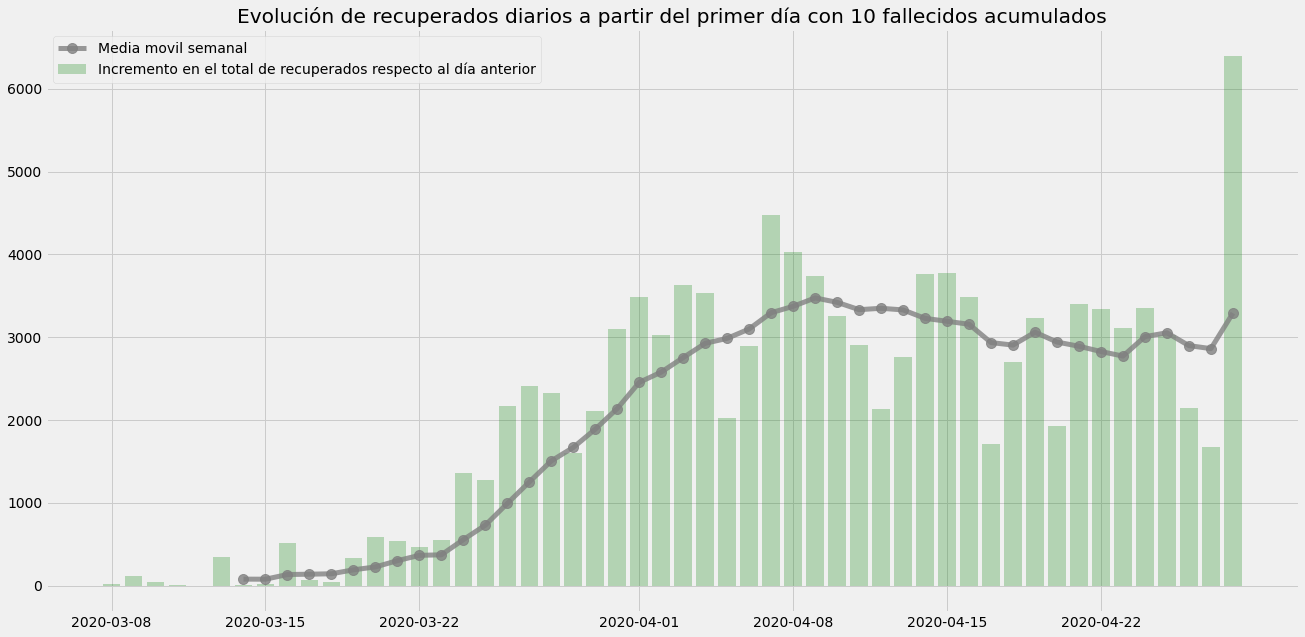

In [12]:
# Let's build our plot
# Set up plot 
fig, ax1 = plt.subplots(figsize=(20,10))
ax2 = ax1 # set up the 2nd axis

#Next lines plot the line of the plot
ax1.plot(data_sem['Diferencia recuperados dia anterior'],alpha=1.8,color='grey',
         label='Media movil semanal',marker='o', markersize=10,linewidth=5)

#Next lines plot the bar chat part of the plot
ax2.bar(data_es.index, data_es["Diferencia recuperados dia anterior"],width=0.8, alpha=0.25, color='green',
       label='Incremento en el total de recuperados respecto al día anterior')

ax1.grid(b=True) #Turn on grid

#set up the title and legend
ax1.set_title('Evolución de recuperados diarios a partir del primer día con 10 fallecidos acumulados')
ax1.legend()
plt.savefig(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\imagenes\recuperados.png');


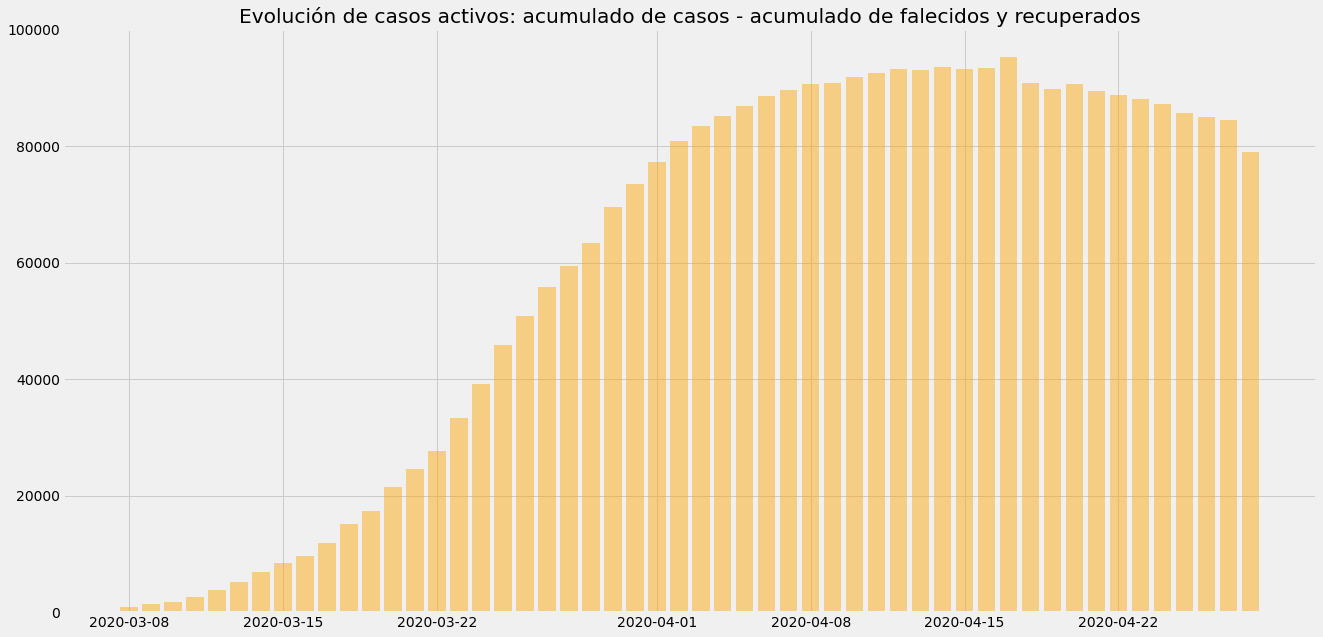

In [13]:
# Let's build our plot
# Set up plot 
fig, ax1 = plt.subplots(figsize=(20,10))
ax2 = ax1 # set up the 2nd axis

#Next lines plot the bar chat part of the plot
ax2.bar(data_es.index, data_es["Casos"] - data_es["Fallecidos"] - data_es["Recuperados"],
        width=0.8, alpha=0.45, color='orange')

ax1.grid(b=True) #Turn on grid

#set up the title and legend
ax1.set_title('Evolución de casos activos: acumulado de casos - acumulado de falecidos y recuperados')
plt.savefig(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\imagenes\casos_activos.png');


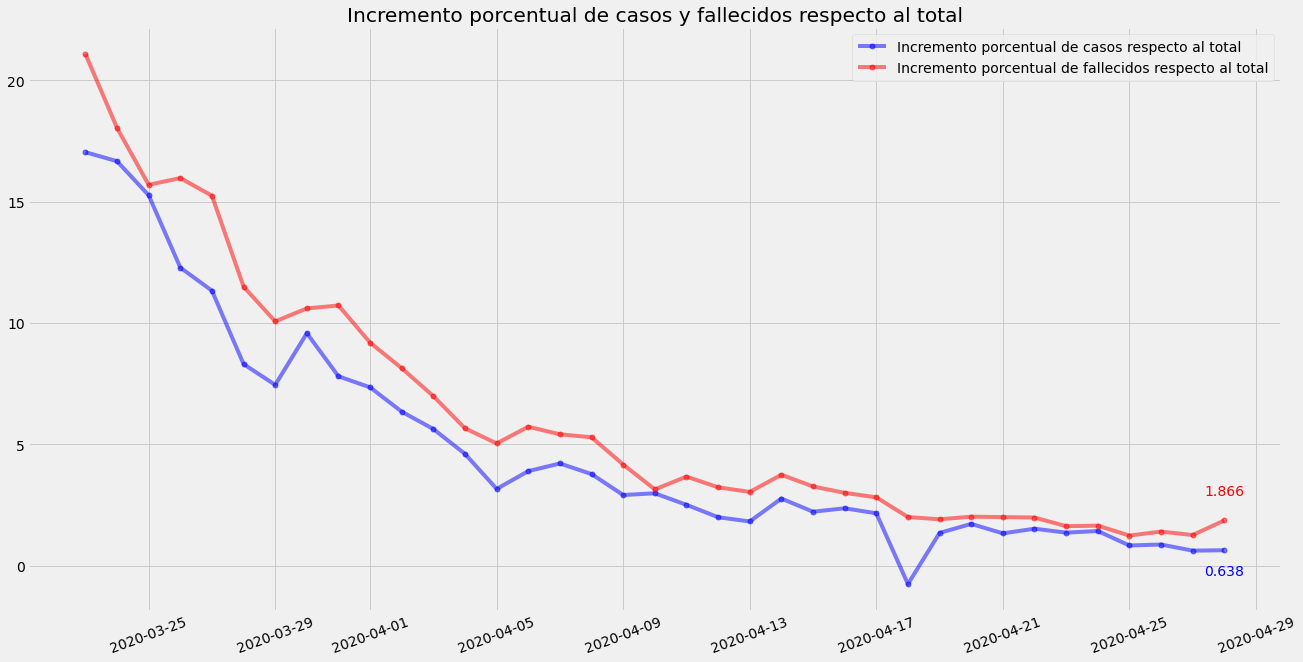

In [14]:
start, end = '2020-03-23 00:00:00', data_es.index.max()
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data_es.loc[start:end, 'Incremento porcentual de casos respecto al total'],
marker='o', markersize=5, linestyle='-',alpha=0.5,color='blue',
        label='Incremento porcentual de casos respecto al total')

ax.plot(data_es.loc[start:end, 'Incremento porcentual de fallecidos respecto al total'],
marker='o', markersize=5, alpha=0.5,color='red',linestyle='-', label='Incremento porcentual de fallecidos respecto al total')

plt.xticks(rotation=20)
plt.title("Incremento porcentual de casos y fallecidos respecto al total")

plt.annotate(data_es.loc[end, 'Incremento porcentual de casos respecto al total'], # this is the text
                 (end,data_es.loc[end, 'Incremento porcentual de casos respecto al total']), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-25), # distance from text to points (x,y)
                 ha='center',color='blue') # horizontal alignment can be left, right or center
plt.annotate(data_es.loc[end, 'Incremento porcentual de fallecidos respecto al total'], # this is the text
                 (end,data_es.loc[end, 'Incremento porcentual de fallecidos respecto al total']), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,25), # distance from text to points (x,y)
                 ha='center',color='red') # horizontal alignment can be left, right or center

ax.legend()
plt.savefig(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\imagenes\incremento_porcentual.png');


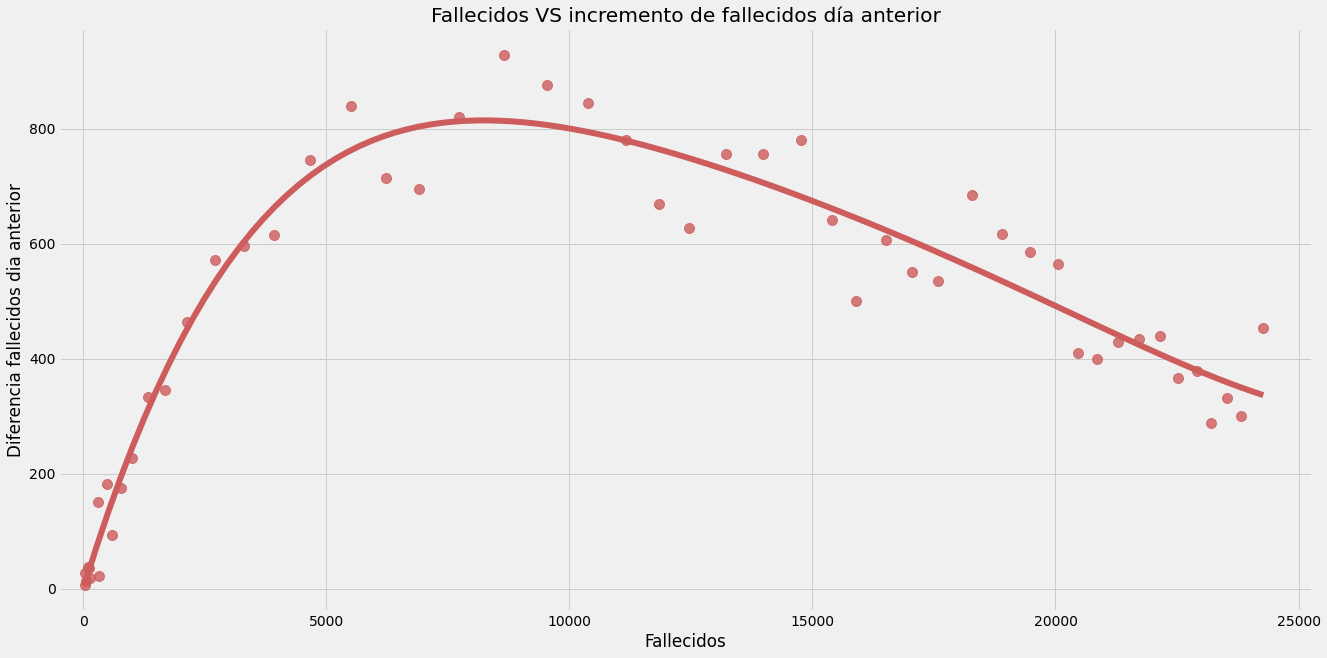

In [15]:
fig, ax = plt.subplots(figsize=(20,10))

start, end = data_es.index.min(), data_es.index.max()
X = data_es.loc[start:end, 'Fallecidos']
Y = data_es.loc[start:end, 'Diferencia fallecidos dia anterior']

ax = sns.regplot(x=X, y=Y, data=data_es,scatter_kws={"s": 100},order=5, ci=False,color='indianred')
plt.title("Fallecidos VS incremento de fallecidos día anterior")
ax.set(xlim=(-500, data_es["Fallecidos"].max() + 1000))
plt.savefig(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\imagenes\fallecidos_VS_incremento.png');



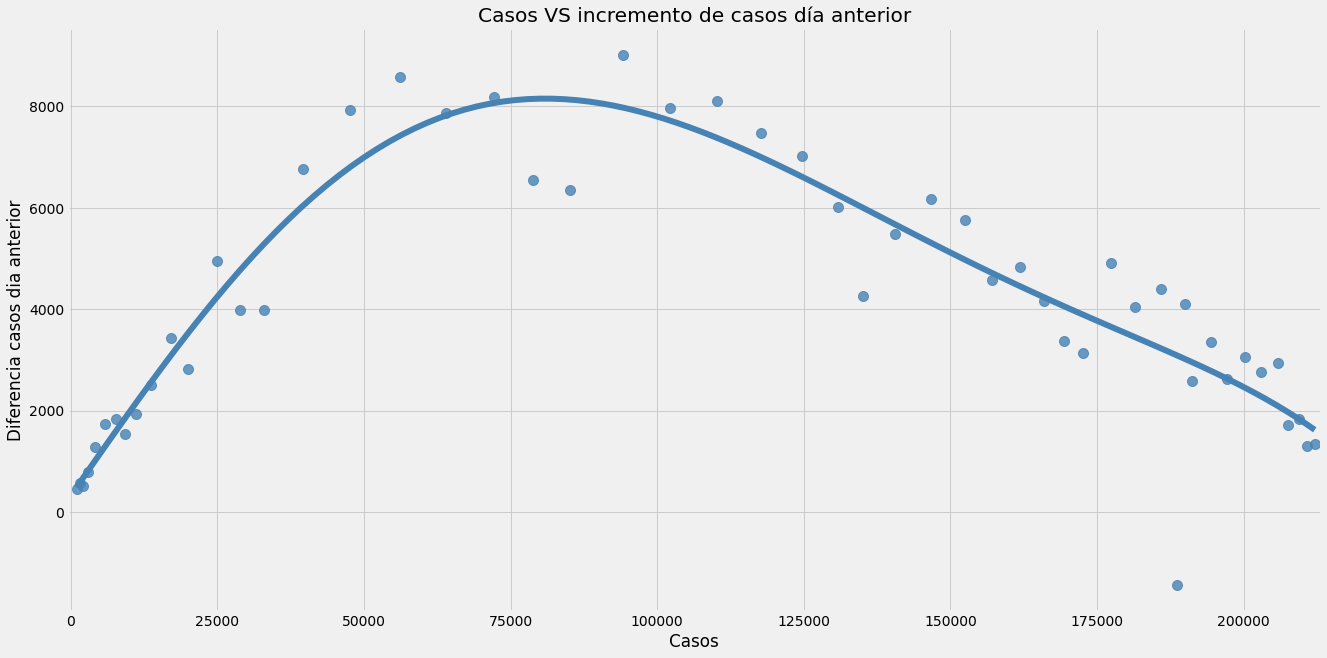

In [16]:
fig, ax = plt.subplots(figsize=(20,10))

start, end = data_es.index.min(), data_es.index.max()
X = data_es.loc[start:end, 'Casos']
Y = data_es.loc[start:end, 'Diferencia casos dia anterior']

ax = sns.regplot(x=X, y=Y, data=data_es,scatter_kws={"s": 100},order=5, ci=True,color='steelblue')
ax.set(xlim=(-500, data_es["Casos"].max() + 1000))

plt.title("Casos VS incremento de casos día anterior")
plt.savefig(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\imagenes\casos_VS_incremento.png');



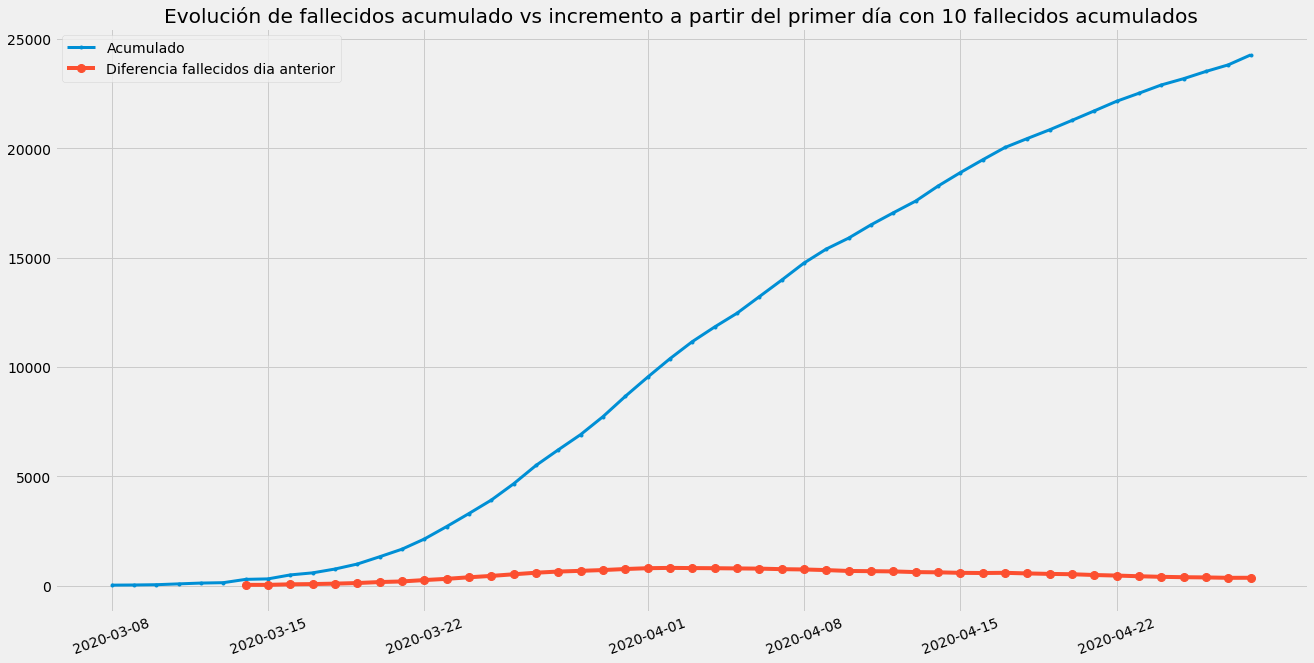

In [17]:
start, end = data_es.index.min(), data_es.index.max()
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data_es.loc[start:end, 'Fallecidos'],
marker='.', linestyle='-', linewidth=3, label='Acumulado')
ax.plot(data_sem.loc[start:end, 'Diferencia fallecidos dia anterior'],
marker='o', markersize=8, linestyle='-', label='Diferencia fallecidos dia anterior')
plt.xticks(rotation=20)
plt.title("Evolución de fallecidos acumulado vs incremento a partir del primer día con 10 fallecidos acumulados")
ax.legend();

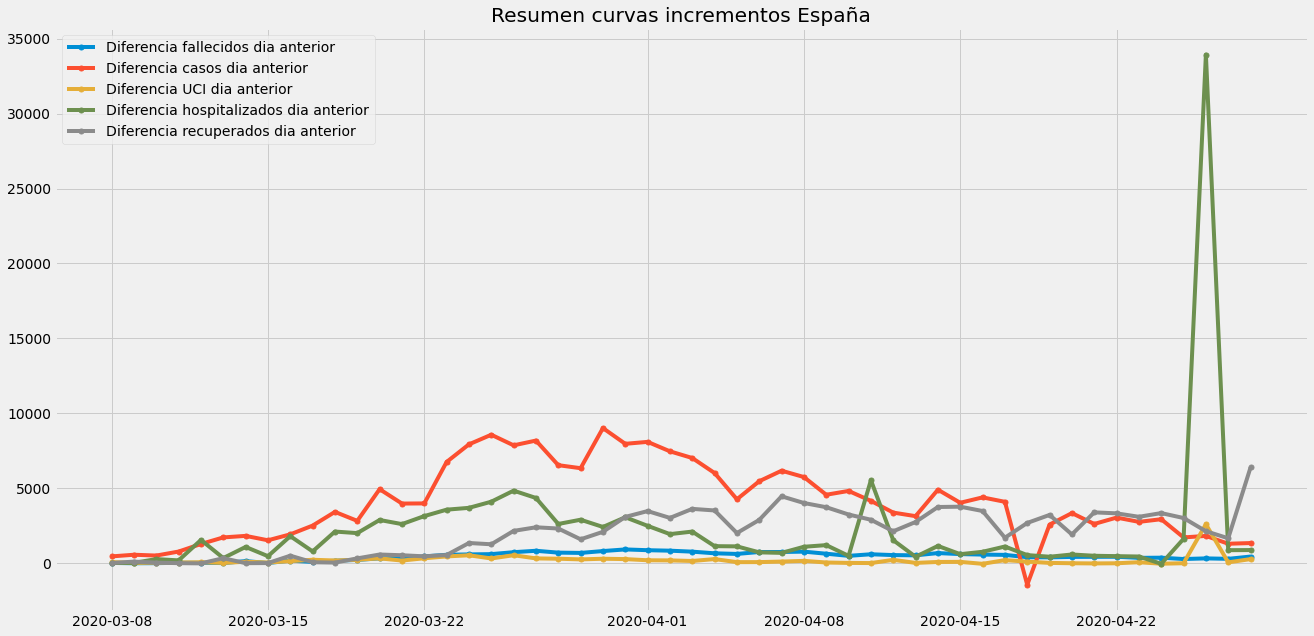

In [18]:
start, end = data_es.index.min(), data_es.index.max()
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data_es.loc[start:end, 'Diferencia fallecidos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia fallecidos dia anterior')
ax.plot(data_es.loc[start:end, 'Diferencia casos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia casos dia anterior')
ax.plot(data_es.loc[start:end, 'Diferencia UCI dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia UCI dia anterior')
ax.plot(data_es.loc[start:end, 'Diferencia hospitalizados dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia hospitalizados dia anterior')
ax.plot(data_es.loc[start:end, 'Diferencia recuperados dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia recuperados dia anterior')
plt.title("Resumen curvas incrementos España");
ax.legend();

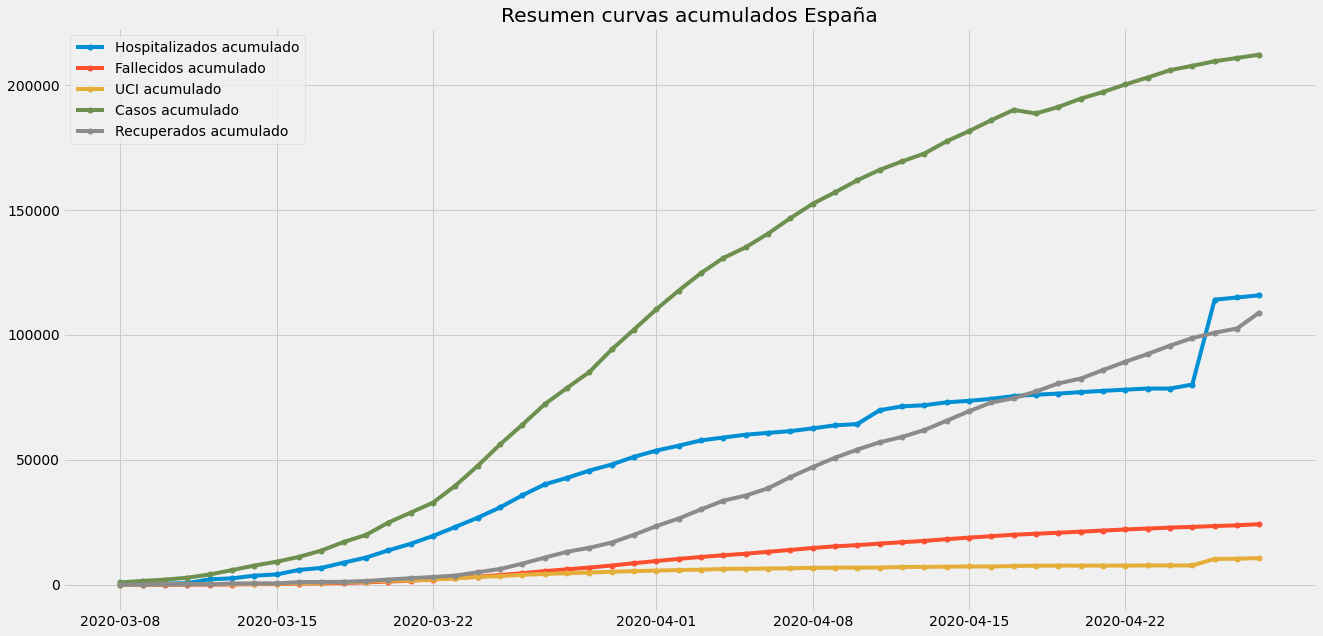

In [19]:
start, end = data_es.index.min(), data_es.index.max()
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(20,10))

ax.plot(data_es.loc[start:end, 'Hospitalizados'],
marker='o', markersize=5, linestyle='-', label='Hospitalizados acumulado')
ax.plot(data_es.loc[start:end, 'Fallecidos'],
marker='o', markersize=5, linestyle='-', label='Fallecidos acumulado')
ax.plot(data_es.loc[start:end, 'UCI'],
marker='o', markersize=5, linestyle='-', label='UCI acumulado')
ax.plot(data_es.loc[start:end, 'Casos'],
marker='o', markersize=5, linestyle='-', label='Casos acumulado')
ax.plot(data_es.loc[start:end, 'Recuperados'],
marker='o', markersize=5, linestyle='-', label='Recuperados acumulado')
plt.title("Resumen curvas acumulados España");
ax.legend();

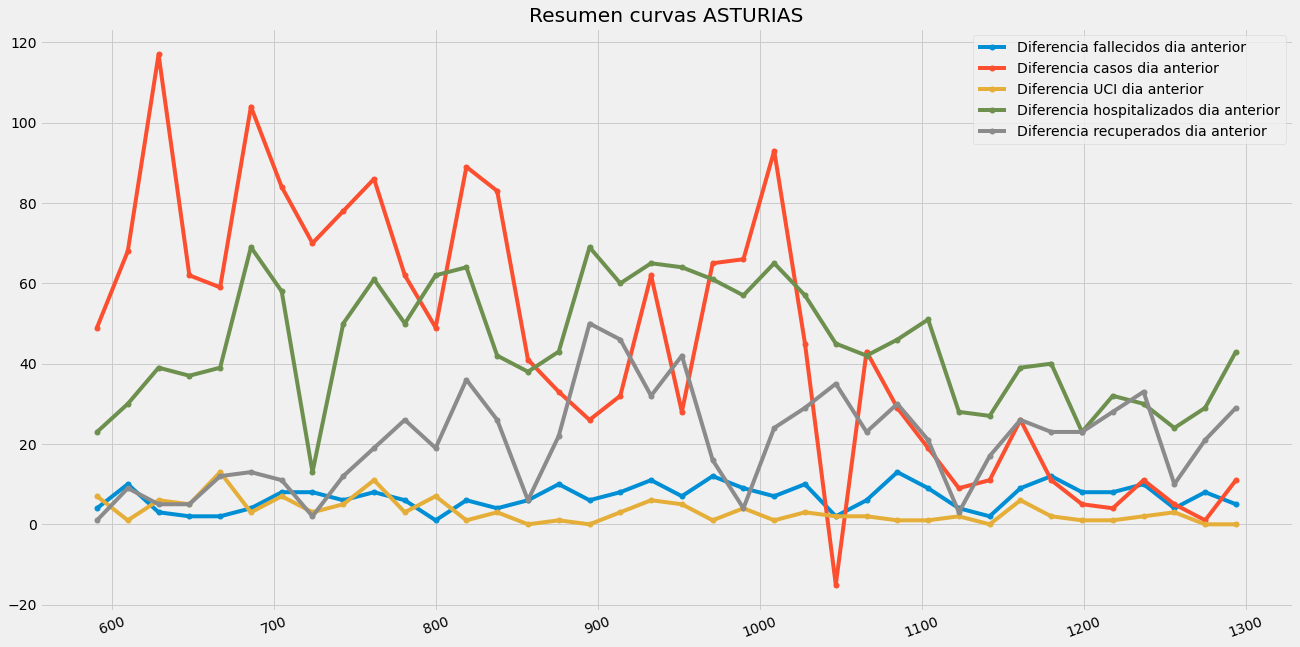

In [20]:
#Introducir código ISO de la comunidad a analizar (ejemplo Asturias) 
data = data[data["Fallecidos"] > 10]

start, end = data[data["CCAA Codigo ISO"] == "AS"].index.min(), data[data["CCAA Codigo ISO"] == "AS"].index.max()
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data[data["CCAA Codigo ISO"] == "AS"].loc[start:end, 'Diferencia fallecidos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia fallecidos dia anterior')
ax.plot(data[data["CCAA Codigo ISO"] == "AS"].loc[start:end, 'Diferencia casos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia casos dia anterior')
ax.plot(data[data["CCAA Codigo ISO"] == "AS"].loc[start:end, 'Diferencia UCI dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia UCI dia anterior')
ax.plot(data[data["CCAA Codigo ISO"] == "AS"].loc[start:end, 'Diferencia hospitalizados dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia hospitalizados dia anterior')
ax.plot(data[data["CCAA Codigo ISO"] == "AS"].loc[start:end, 'Diferencia recuperados dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia recuperados dia anterior')
ax.legend()
plt.xticks(rotation=20)
plt.title("Resumen curvas ASTURIAS");

Casos positivos: 51721.0
Casos Sospechosos: 110979.016
Numero de tests totales: 162700.016


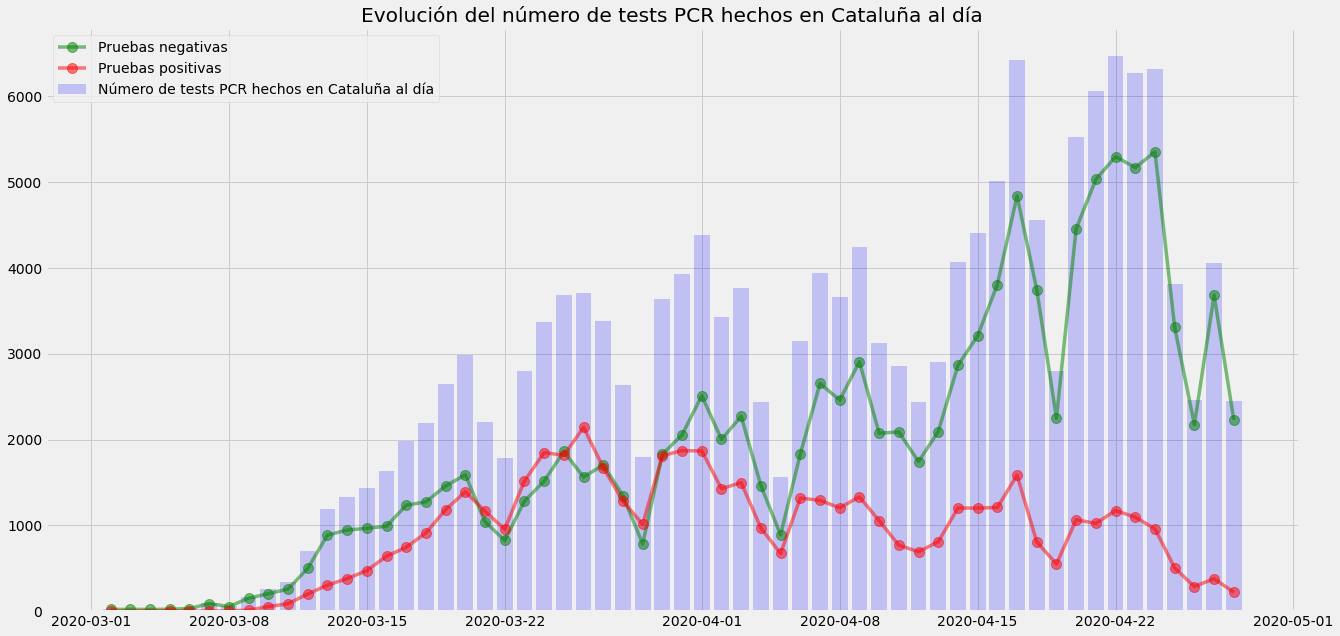

In [21]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax2 = ax1 # set up the 2nd axis

#Next lines plot the line of the plot
ax1.plot(data_cat_gropued_resultado[data_cat_gropued_resultado['TipusCasDescripcio'] == "Sospitós"]["NumCasos"]
         ,alpha=0.5,color='green',
         label='Pruebas negativas',marker='o', markersize=10,linewidth=3.5)

ax1.plot(data_cat_gropued_resultado[data_cat_gropued_resultado['TipusCasDescripcio'] == "Positiu"]["NumCasos"]
         ,alpha=0.5,color='red',
         label='Pruebas positivas',marker='o', markersize=10,linewidth=3.5)


#Next lines plot the bar chat part of the plot
ax2.bar(data_cat_gropued.index, data_cat_gropued["NumCasos"],width=0.8, alpha=0.2, color='blue',
       label='Número de tests PCR hechos en Cataluña al día')

ax1.grid(b=True) #Turn on grid

print ("Casos positivos:", data_cat_gropued_resultado[data_cat_gropued_resultado['TipusCasDescripcio'] == "Positiu"]["NumCasos"].sum())
print ("Casos Sospechosos:", data_cat_gropued_resultado[data_cat_gropued_resultado['TipusCasDescripcio'] == "Sospitós"]["NumCasos"].sum())
print ("Numero de tests totales:", data_cat_gropued_resultado["NumCasos"].sum())

#set up the title and legend
ax1.set_title('Evolución del número de tests PCR hechos en Cataluña al día')
ax1.legend()
plt.savefig(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\imagenes\tests.png');



In [22]:
data_sem_jh = data_sem_jh[data_sem_jh["Fallecidos"] >= 10]
data_sem_jh = data_sem_jh.reset_index()
data_sem_jh = data_sem_jh.set_index('Fecha')
data_sem_jh = data_sem_jh.reset_index()
data_sem_jh["Time_delta"] = 0
data_sem_jh["Time_delta"] = pd.to_timedelta(data_sem_jh["Time_delta"])


In [23]:
for geo in data_sem_jh["Country/Region"].unique():
    data_sem_out = data_sem_jh[data_sem_jh["Country/Region"] == geo]
    data_sem_out["Time_delta"] = data_sem_out[data_sem_out["Country/Region"] == geo]["Fecha"] - data_sem_out[data_sem_out["Country/Region"] == geo]["Fecha"].min()
    data_sem_jh[data_sem_jh["Country/Region"] == geo] = data_sem_out[data_sem_out["Country/Region"] == geo]

In [24]:
data_sem_jh["Time_delta"] = data_sem_jh["Time_delta"].astype('timedelta64[D]')
data_sem_jh = data_sem_jh.set_index('Time_delta')


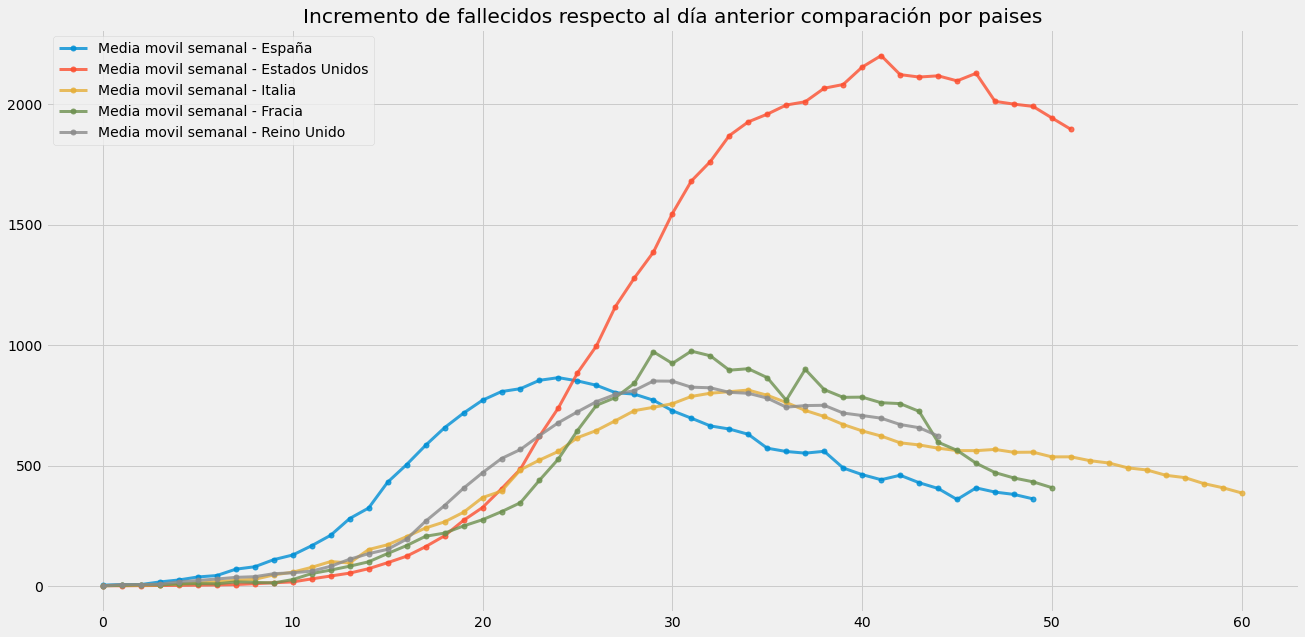

In [25]:
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & 
                    (data_sem_jh["Fallecidos"] > 10)]['Diferencia fallecidos dia anterior'],
marker='o', alpha=0.8,linewidth=3, markersize=5, linestyle='-', label='Media movil semanal - España')

ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "US") & 
                    (data_sem_jh["Fallecidos"] > 10)]['Diferencia fallecidos dia anterior'],
marker='o', alpha=0.8,linewidth=3,markersize=5, linestyle='-', label='Media movil semanal - Estados Unidos')

ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "Italy") & 
                    (data_sem_jh["Fallecidos"] > 10)]['Diferencia fallecidos dia anterior'],
marker='o',alpha=0.8,linewidth=3, markersize=5, linestyle='-', label='Media movil semanal - Italia')

ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "France") & 
                    (data_sem_jh["Fallecidos"] > 10)]['Diferencia fallecidos dia anterior'],
marker='o',alpha=0.8 ,linewidth=3,markersize=5, linestyle='-', label='Media movil semanal - Fracia')

ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "United Kingdom") 
                    & (data_sem_jh["Fallecidos"] > 10)]['Diferencia fallecidos dia anterior'],
marker='o',alpha=0.8,linewidth=3, markersize=5, linestyle='-', label='Media movil semanal - Reino Unido')

plt.title("Incremento de fallecidos respecto al día anterior comparación por paises")
ax.legend()
plt.savefig(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\imagenes\paises.png');

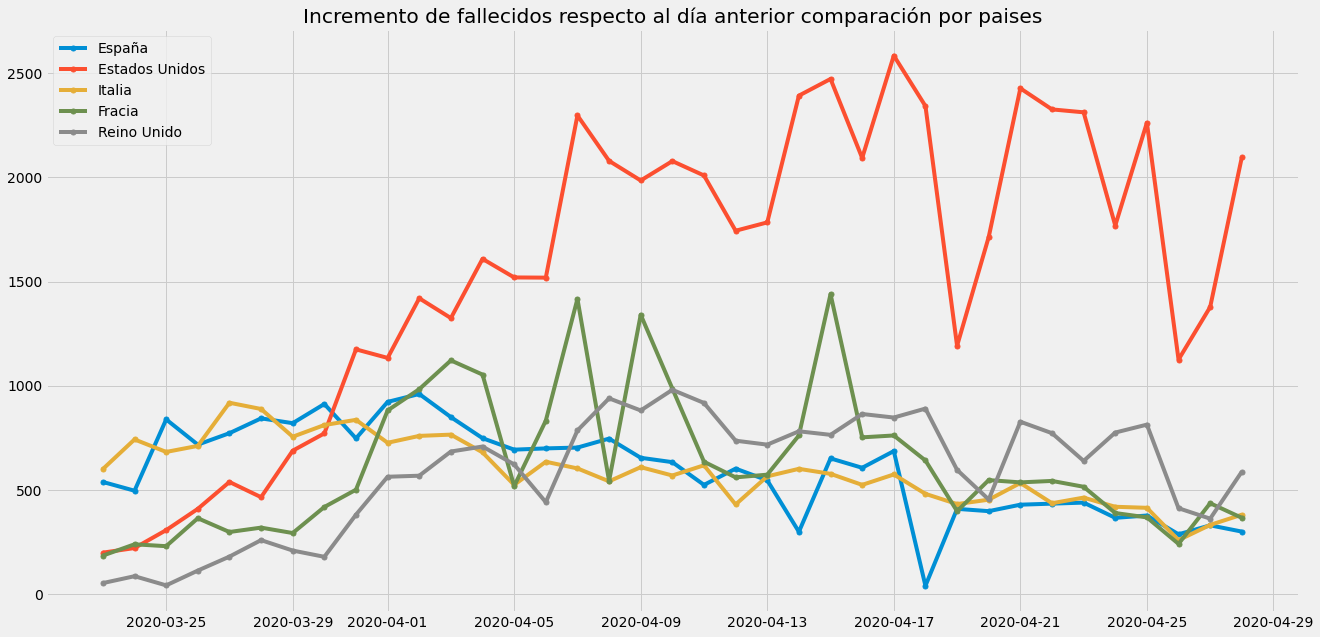

In [26]:
start, end = '2020-03-23 00:00:00', data_jh[(data_jh["Country/Region"] == "Spain") & (data_jh["Fallecidos"] > 10)].index.max()
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data_jh[(data_jh["Country/Region"] == "Spain") & (data_jh["Fallecidos"] > 10)].loc[start:end, 'Diferencia fallecidos dia anterior'],
marker='o', markersize=5, linestyle='-', label='España')
ax.plot(data_jh[(data_jh["Country/Region"] == "US") & (data_jh["Fallecidos"] > 10)].loc[start:end, 'Diferencia fallecidos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Estados Unidos')
ax.plot(data_jh[(data_jh["Country/Region"] == "Italy") & (data_jh["Fallecidos"] > 10)].loc[start:end, 'Diferencia fallecidos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Italia')
ax.plot(data_jh[(data_jh["Country/Region"] == "France") & (data_jh["Fallecidos"] > 10)].loc[start:end, 'Diferencia fallecidos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Fracia')
ax.plot(data_jh[(data_jh["Country/Region"] == "United Kingdom") & (data_jh["Fallecidos"] > 10)].loc[start:end, 'Diferencia fallecidos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Reino Unido')
plt.title("Incremento de fallecidos respecto al día anterior comparación por paises");
ax.legend();

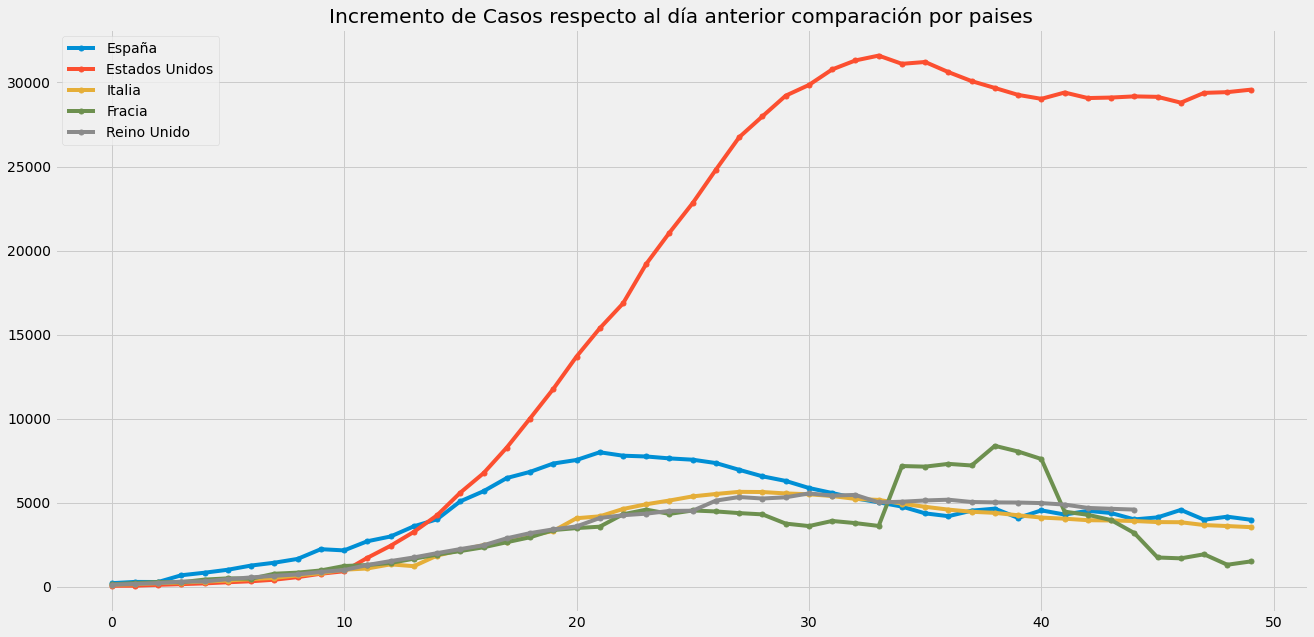

In [27]:
start, end = data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Fallecidos"] > 10)].index.min(), data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Fallecidos"] > 10)].index.max()
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Casos"] > 10)].loc[start:end, 'Diferencia casos dia anterior'],
marker='o', markersize=5, linestyle='-', label='España')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "US") & (data_sem_jh["Casos"] > 10)].loc[start:end, 'Diferencia casos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Estados Unidos')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "Italy") & (data_sem_jh["Casos"] > 10)].loc[start:end, 'Diferencia casos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Italia')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "France") & (data_sem_jh["Casos"] > 10)].loc[start:end, 'Diferencia casos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Fracia')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "United Kingdom") & (data_sem_jh["Casos"] > 10)].loc[start:end, 'Diferencia casos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Reino Unido')
plt.title("Incremento de Casos respecto al día anterior comparación por paises");
ax.legend();

In [28]:
data_jh[["Country/Region","Diferencia casos dia anterior"]].sort_values("Diferencia casos dia anterior",
                                                                            ascending=False).head(10)

,Country/Region,Diferencia casos dia anterior
Fecha,,
2020-04-24,US,36188.0
2020-04-09,US,34126.0
2020-04-10,US,33755.0
2020-04-04,US,33283.0
2020-04-25,US,32796.0
2020-04-18,US,32491.0
2020-04-17,US,32114.0
2020-04-03,US,31745.0
2020-04-08,US,31533.0


In [29]:
data_jh[["Country/Region","Diferencia fallecidos dia anterior"]].sort_values("Diferencia fallecidos dia anterior",
                                                                            ascending=False).head(10)

,Country/Region,Diferencia fallecidos dia anterior
Fecha,,
2020-04-17,US,2584.0
2020-04-15,US,2472.0
2020-04-21,US,2427.0
2020-04-14,US,2392.0
2020-04-18,US,2342.0
2020-04-22,US,2326.0
2020-04-23,US,2312.0
2020-04-07,US,2297.0
2020-04-25,US,2262.0


In [30]:
def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

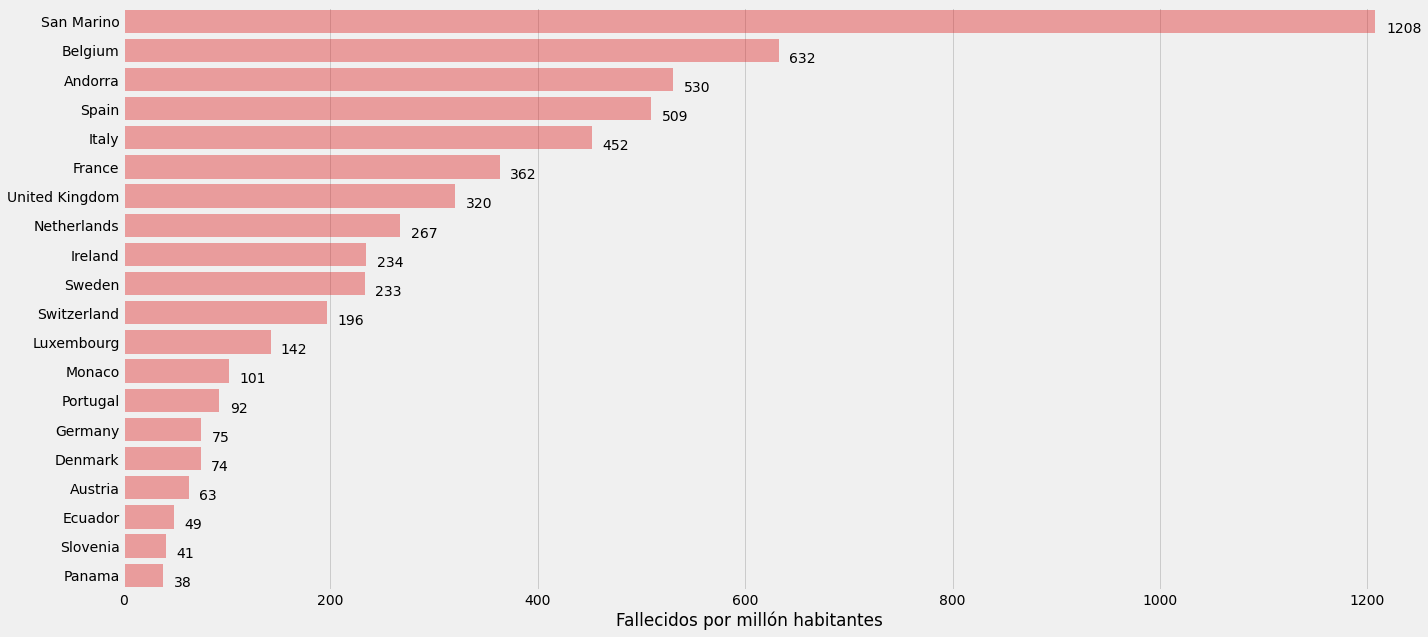

In [31]:

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(20,10))

# Load the example car crash dataset
df = data_jh.groupby(["Country/Region"]).max()["Fallecidos por millón habitantes"].sort_values(ascending=False).to_frame().reset_index().head(20)

# Plot the total crashes
sns.barplot(x="Fallecidos por millón habitantes", y="Country/Region", data=df,
            label="Total", color="r", alpha=0.4)



# Add a legend and informative axis label
ax.set(xlim=(0, df["Fallecidos por millón habitantes"].max()), ylabel="",
       xlabel="Fallecidos por millón habitantes")
show_values_on_bars(ax, "h", 10);


In [32]:
fecha = data_jh.index.max()

df = data_jh[data_jh["Fallecidos"] > 25].loc[fecha, ["Country/Region","Fallecidos",
                                                'Incremento porcentual de fallecidos respecto al total']].sort_values(by='Incremento porcentual de fallecidos respecto al total',
                                                                                                                      ascending=False).head(10)
df["Días que tarda en doblar fallecidos"] = 100/df["Incremento porcentual de fallecidos respecto al total"]

df["Días que tarda en doblar fallecidos"] = df["Días que tarda en doblar fallecidos"].round(3)
df["Incremento porcentual de fallecidos respecto al total"] = df["Incremento porcentual de fallecidos respecto al total"].round(3)

df

,Country/Region,Fallecidos,Incremento porcentual de fallecidos respecto al total,Días que tarda en doblar fallecidos
Fecha,,,,
2020-04-28,Ecuador,871,23.881,4.188
2020-04-28,Brazil,5083,9.443,10.590
2020-04-28,Nigeria,44,9.091,11.000
2020-04-28,Mexico,1569,8.604,11.622
2020-04-28,North Macedonia,71,8.451,11.833
2020-04-28,Peru,854,8.431,11.861
2020-04-28,Russia,867,8.420,11.877
2020-04-28,Ukraine,239,7.950,12.579
2020-04-28,United Arab Emirates,89,7.865,12.714


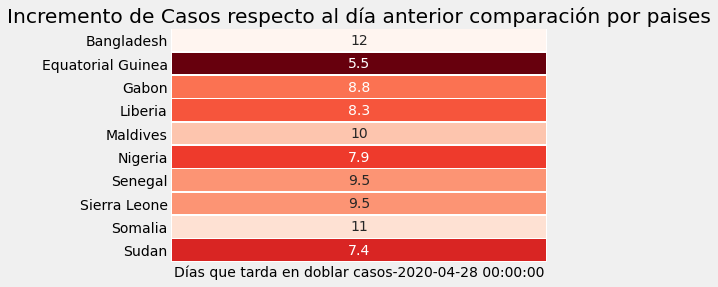

In [33]:
fecha = data_jh.index.max()

df = data_jh[data_jh["Casos"] > 100].loc[fecha, ["Country/Region","Casos",
                                                'Incremento porcentual de casos respecto al total']].sort_values(by='Incremento porcentual de casos respecto al total',
                                                                                                                      ascending=False).head(10)
df["Días que tarda en doblar casos"] = 100/df["Incremento porcentual de casos respecto al total"]

df["Días que tarda en doblar casos"] = df["Días que tarda en doblar casos"].round(3)
df["Incremento porcentual de casos respecto al total"] = df["Incremento porcentual de casos respecto al total"].round(3)
df = df.loc[:, df.columns != 'Casos']
df = df.loc[:, df.columns != 'Incremento porcentual de casos respecto al total']
df = df.sort_values(by='Días que tarda en doblar casos',ascending=False)
df = df.reset_index().pivot("Country/Region","Fecha")
ax = sns.heatmap(df, annot=True,cmap="Reds_r", linewidths=.5,cbar=False)
plt.title("Incremento de Casos respecto al día anterior comparación por paises")
plt.ylabel('')
plt.xlabel('');



In [34]:
df

,Días que tarda en doblar casos
Fecha,2020-04-28
Country/Region,
Bangladesh,11.770
Equatorial Guinea,5.526
Gabon,8.815
Liberia,8.294
Maldives,10.417
Nigeria,7.856
Senegal,9.460
Sierra Leone,9.455


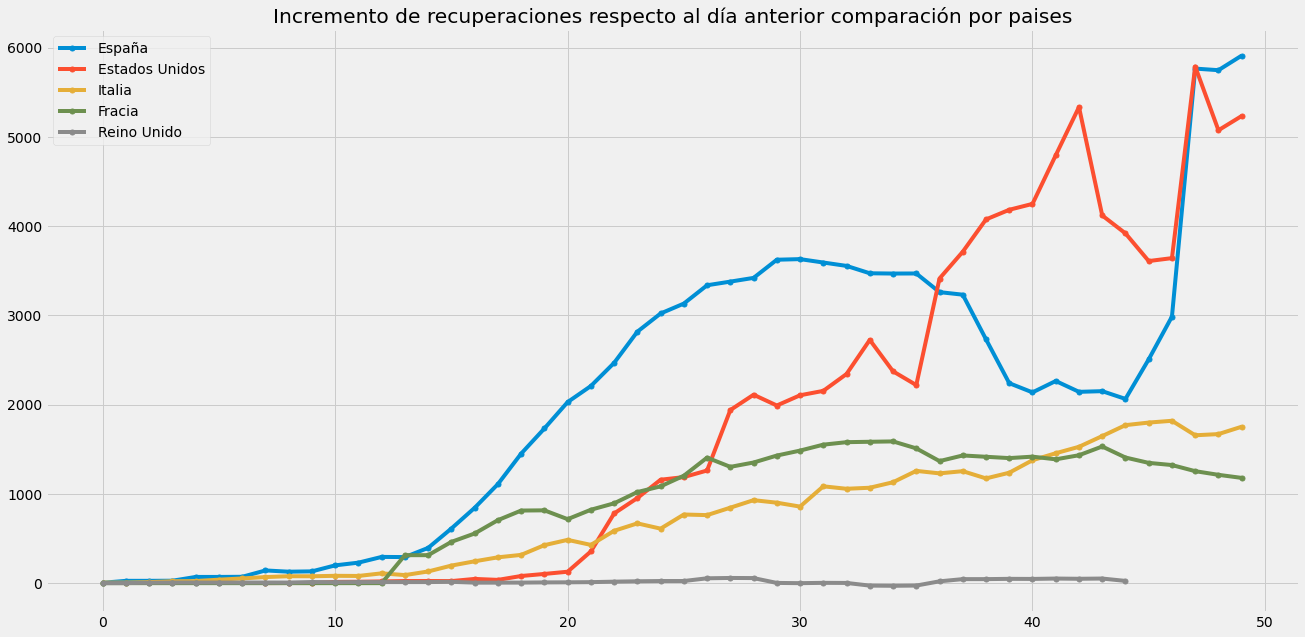

In [35]:
start, end = data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Recuperados"] > 10)].index.min(), data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Recuperados"] > 10)].index.max()
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Recuperados"] > 10)].loc[start:end, 'Diferencia recuperados dia anterior'],
marker='o', markersize=5, linestyle='-', label='España')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "US") & (data_sem_jh["Recuperados"] > 10)].loc[start:end, 'Diferencia recuperados dia anterior'],
marker='o', markersize=5, linestyle='-', label='Estados Unidos')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "Italy") & (data_sem_jh["Recuperados"] > 10)].loc[start:end, 'Diferencia recuperados dia anterior'],
marker='o', markersize=5, linestyle='-', label='Italia')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "France") & (data_sem_jh["Recuperados"] > 10)].loc[start:end, 'Diferencia recuperados dia anterior'],
marker='o', markersize=5, linestyle='-', label='Fracia')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "United Kingdom") & (data_sem_jh["Recuperados"] > 10)].loc[start:end, 'Diferencia recuperados dia anterior'],
marker='o', markersize=5, linestyle='-', label='Reino Unido')
plt.title("Incremento de recuperaciones respecto al día anterior comparación por paises");
ax.legend();

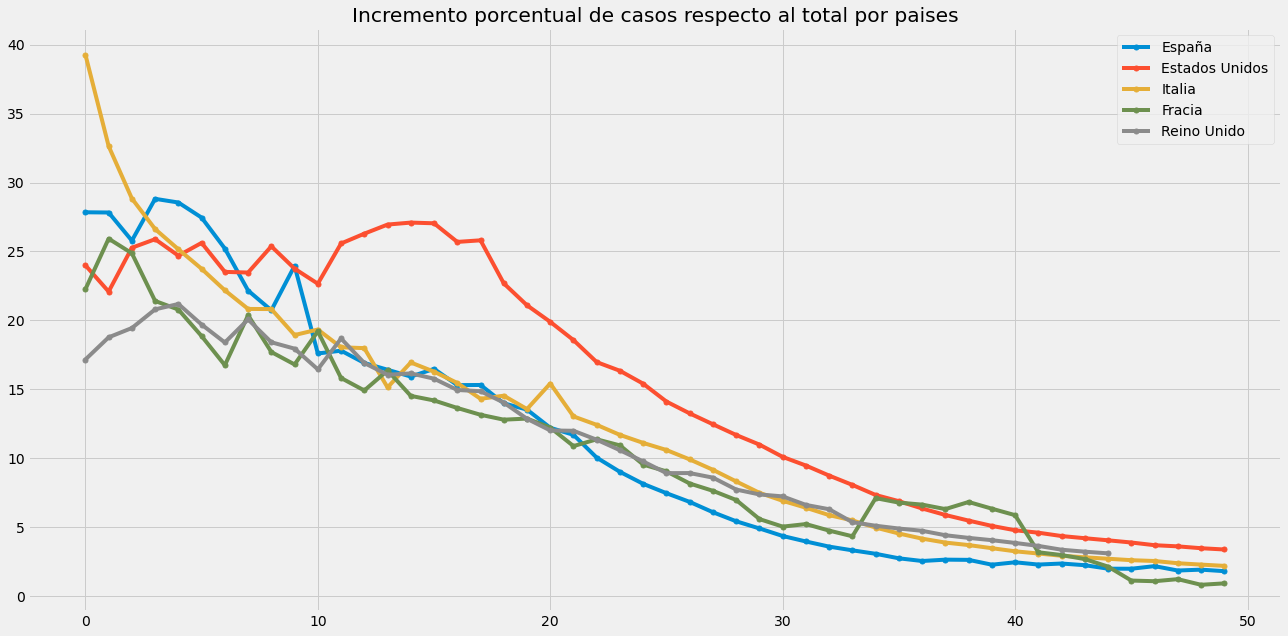

In [36]:
start, end = data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Casos"] > 10)].index.min(), data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Recuperados"] > 10)].index.max()
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Casos"] > 10)].loc[start:end, 'Incremento porcentual de casos respecto al total'],
marker='o', markersize=5, linestyle='-', label='España')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "US") & (data_sem_jh["Casos"] > 10)].loc[start:end, 'Incremento porcentual de casos respecto al total'],
marker='o', markersize=5, linestyle='-', label='Estados Unidos')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "Italy") & (data_sem_jh["Casos"] > 10)].loc[start:end, 'Incremento porcentual de casos respecto al total'],
marker='o', markersize=5, linestyle='-', label='Italia')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "France") & (data_sem_jh["Casos"] > 10)].loc[start:end, 'Incremento porcentual de casos respecto al total'],
marker='o', markersize=5, linestyle='-', label='Fracia')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "United Kingdom") & (data_sem_jh["Casos"] > 10)].loc[start:end, 'Incremento porcentual de casos respecto al total'],
marker='o', markersize=5, linestyle='-', label='Reino Unido')
plt.title("Incremento porcentual de casos respecto al total por paises");
ax.legend();

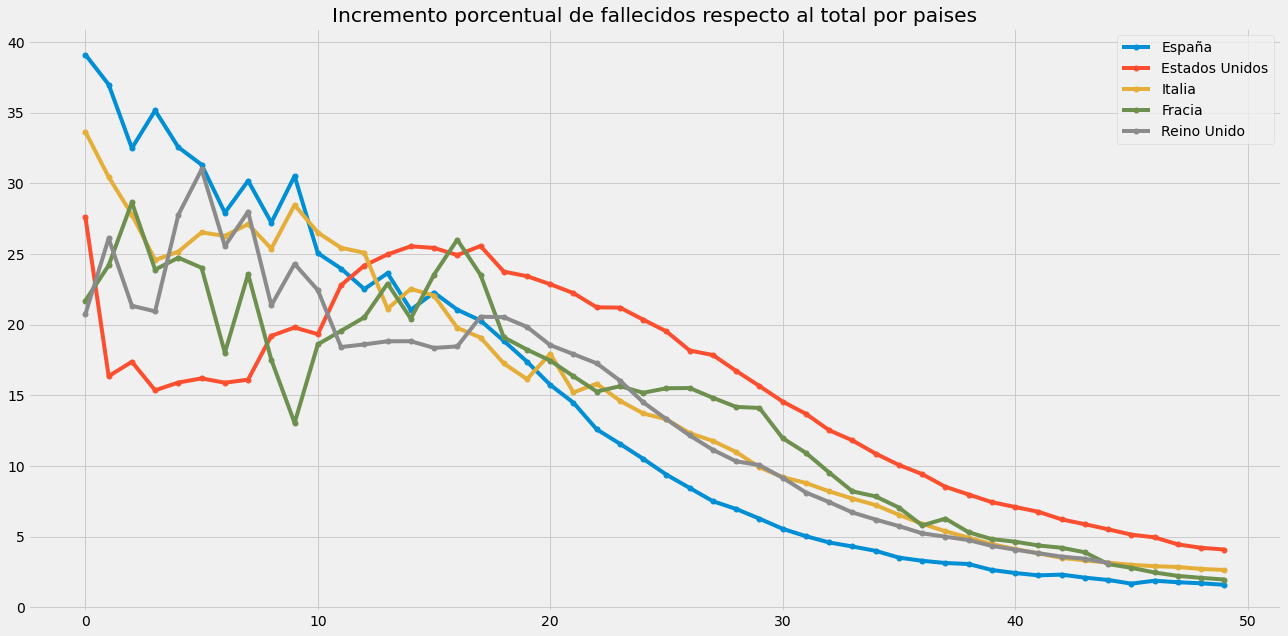

In [37]:
start, end = data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Fallecidos"] > 10)].index.min(), data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Recuperados"] > 10)].index.max()
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Fallecidos"] > 10)].loc[start:end, 'Incremento porcentual de fallecidos respecto al total'],
marker='o', markersize=5, linestyle='-', label='España')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "US") & (data_sem_jh["Fallecidos"] > 10)].loc[start:end, 'Incremento porcentual de fallecidos respecto al total'],
marker='o', markersize=5, linestyle='-', label='Estados Unidos')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "Italy") & (data_sem_jh["Fallecidos"] > 10)].loc[start:end, 'Incremento porcentual de fallecidos respecto al total'],
marker='o', markersize=5, linestyle='-', label='Italia')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "France") & (data_sem_jh["Fallecidos"] > 10)].loc[start:end, 'Incremento porcentual de fallecidos respecto al total'],
marker='o', markersize=5, linestyle='-', label='Fracia')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "United Kingdom") & (data_sem_jh["Fallecidos"] > 10)].loc[start:end, 'Incremento porcentual de fallecidos respecto al total'],
marker='o', markersize=5, linestyle='-', label='Reino Unido')
plt.title("Incremento porcentual de fallecidos respecto al total por paises");
ax.legend();

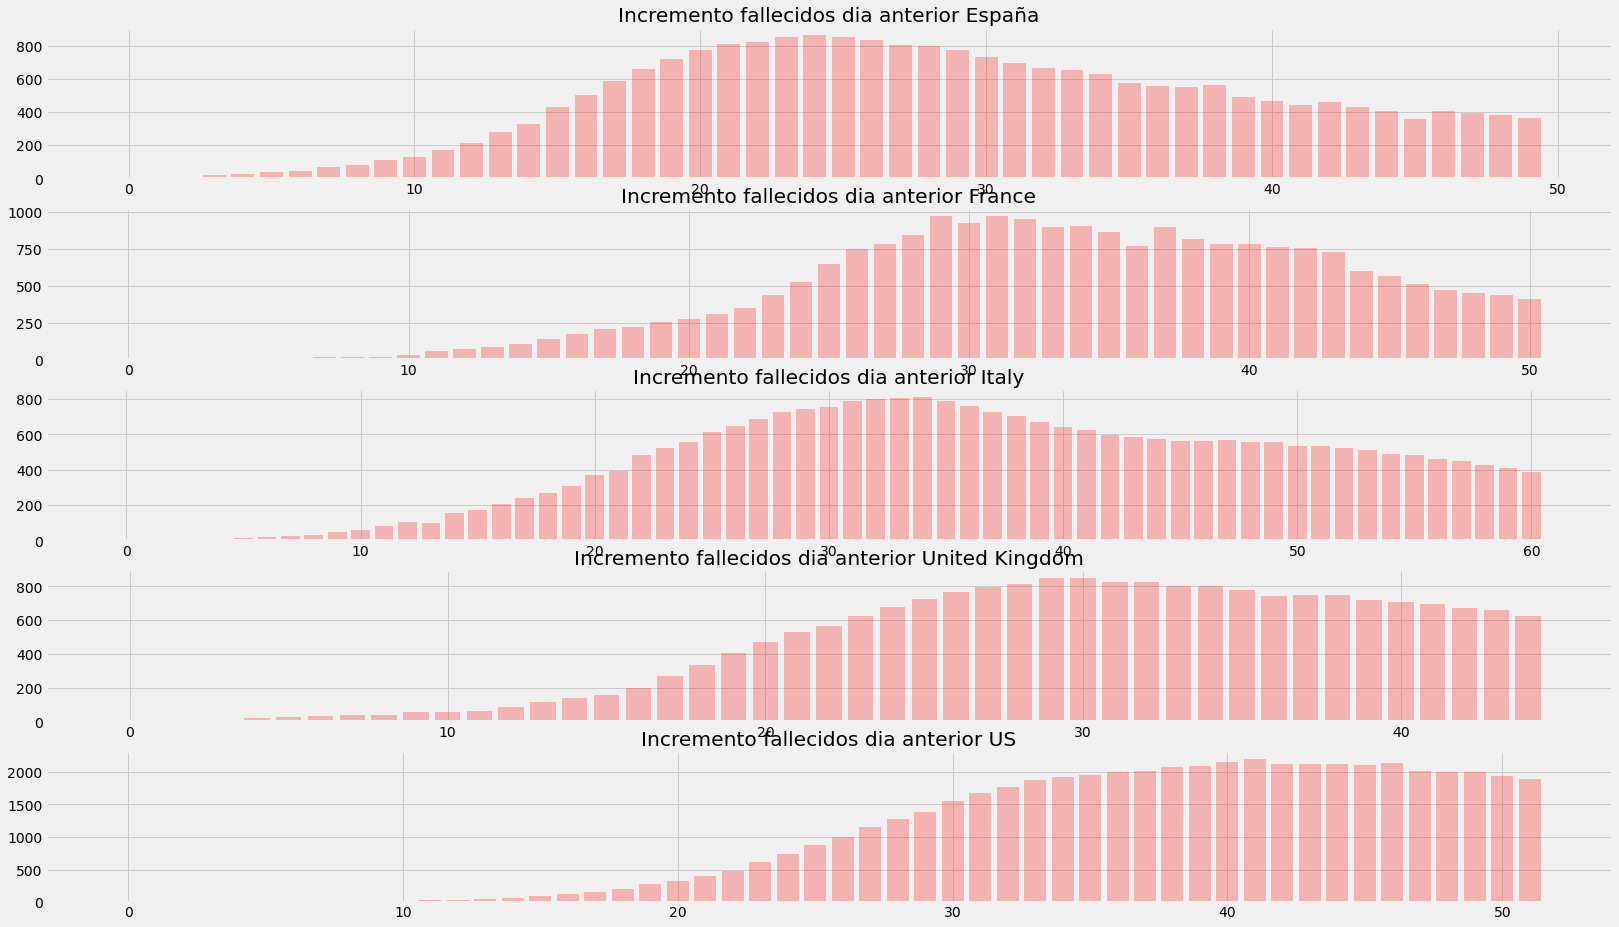

In [38]:
start, end = data_sem_jh.index.min(), data_sem_jh.index.max()
# Let's build our plot
# Set up plot 
fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(5,figsize=(25,15))

#Next lines plot the bar chat part of the plot
ax1.bar(data_sem_jh[data_sem_jh["Country/Region"] == "Spain"].loc[start: end].index, 
        data_sem_jh[data_sem_jh["Country/Region"] == "Spain"]["Diferencia fallecidos dia anterior"].loc[start: end],
        width=0.8, alpha=0.25, color='red')

ax2.bar(data_sem_jh[data_sem_jh["Country/Region"] == "France"].loc[start: end].index, 
        data_sem_jh[data_sem_jh["Country/Region"] == "France"]["Diferencia fallecidos dia anterior"].loc[start: end],
        width=0.8, alpha=0.25, color='red')

ax3.bar(data_sem_jh[data_sem_jh["Country/Region"] == "Italy"].loc[start: end].index, 
        data_sem_jh[data_sem_jh["Country/Region"] == "Italy"]["Diferencia fallecidos dia anterior"].loc[start: end],
        width=0.8, alpha=0.25, color='red')

ax4.bar(data_sem_jh[data_sem_jh["Country/Region"] == "United Kingdom"].loc[start: end].index, 

        data_sem_jh[data_sem_jh["Country/Region"] == "United Kingdom"]["Diferencia fallecidos dia anterior"].loc[start: end],
        width=0.8, alpha=0.25, color='red')

ax5.bar(data_sem_jh[data_sem_jh["Country/Region"] == "US"].loc[start: end].index, 
        data_sem_jh[data_sem_jh["Country/Region"] == "US"]["Diferencia fallecidos dia anterior"].loc[start: end],
        width=0.8, alpha=0.25, color='red')

ax1.grid(b=True) #Turn on grid

#set up the title and legend
ax1.set_title('Incremento fallecidos dia anterior España')
ax2.set_title('Incremento fallecidos dia anterior France')
ax3.set_title('Incremento fallecidos dia anterior Italy')
ax4.set_title('Incremento fallecidos dia anterior United Kingdom')
ax5.set_title('Incremento fallecidos dia anterior US');


In [39]:
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA


In [40]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
data_sem.index.freq="D"
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(np.log(data_sem["Diferencia fallecidos dia anterior"]),order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
                        


ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:298.3439433311447


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1402.4253487213125
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:183.02712238393724
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:46.33572985069629
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:199.10966230321685


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1346.960941037489
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:38.01676206796504
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:35.854952423429765
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:241.16601664840815


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1307.083672501507
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:128.18413451248443
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:2.733547956585753
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:215.65768309811466


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1167.036691360431
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:16.982835735278538
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:8.408506706666653
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:-37.52312698741046


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1534.3317289675665
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:42.54950180847269
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:-39.78243652047397
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:-94.69348956675283
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1739.2820745024833


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:-56.44948463670316
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:-54.47365671991827
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:-51.01396003535295


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:1553.018131328374
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:20.73134005156398
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:-61.52616773257671
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:-105.37012500431386


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:1541.2943522737085
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:-70.7245810720265
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:-69.4005800636823
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:-39.918052568357936


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:1564.4040096537394
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:38.07095039646884
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:-55.077204999791576
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:-96.4674372544034
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:1418.430987094749


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:-55.143471389840165
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:-62.76412137953258
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:-51.5830865913791


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:1321.3421697500114
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:23.358205711731852


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:-63.19078777169429
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:-102.6613201622188
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:1179.1627564060286

C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:-75.94664801150806
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:-81.48290453096259
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:-56.052991642978384


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:1804.278828936373
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:27.641590249419835
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:-80.37647925929141


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:-151.0941090645463


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:1792.1841097506847


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:-92.81347959287174
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:-77.39822113357404


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:-67.42120642035732


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:1544.1293906529647


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:16.151142254203705
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:-101.92860164470609
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:-154.84185751140248


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:1532.4056184199576
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:-98.14792562105967
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:-101.02616309159669


In [41]:
mod2 = sm.tsa.statespace.SARIMAX(np.log(data_sem["Diferencia fallecidos dia anterior"]),
                                order=(0, 1, 0),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results2 = mod2.fit()
print(results2.summary())

                                       SARIMAX Results                                        
Dep. Variable:     Diferencia fallecidos dia anterior   No. Observations:                   52
Model:               SARIMAX(0, 1, 0)x(0, 1, [1], 12)   Log Likelihood                  21.891
Date:                                Wed, 29 Apr 2020   AIC                            -39.782
Time:                                        13:25:40   BIC                            -37.266
Sample:                                    03-08-2020   HQIC                           -39.058
                                         - 04-28-2020                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12       0.2516      0.287      0.877      0.381      -0.311       0.814
sig

Fecha
2020-04-09    739.301072
2020-04-10    733.290982
2020-04-11    682.893054
2020-04-12    681.229884
2020-04-13    647.103561
2020-04-14    615.740472
2020-04-15    567.871933
2020-04-16    558.870915
2020-04-17    546.875046
2020-04-18    563.305896
2020-04-19    523.080161
2020-04-20    508.632651
2020-04-21    502.796041
2020-04-22    454.830099
2020-04-23    457.325295
2020-04-24    423.986690
2020-04-25    385.254138
2020-04-26    384.332904
2020-04-27    370.409296
2020-04-28    361.623574
Freq: D, dtype: float64
2020-04-29    378.703586
2020-04-30    360.903310
2020-05-01    350.158865
2020-05-02    343.571760
2020-05-03    318.486998
2020-05-04    304.000657
2020-05-05    280.170709
2020-05-06    260.509158
2020-05-07    250.323075
2020-05-08    243.615595
Freq: D, dtype: float64


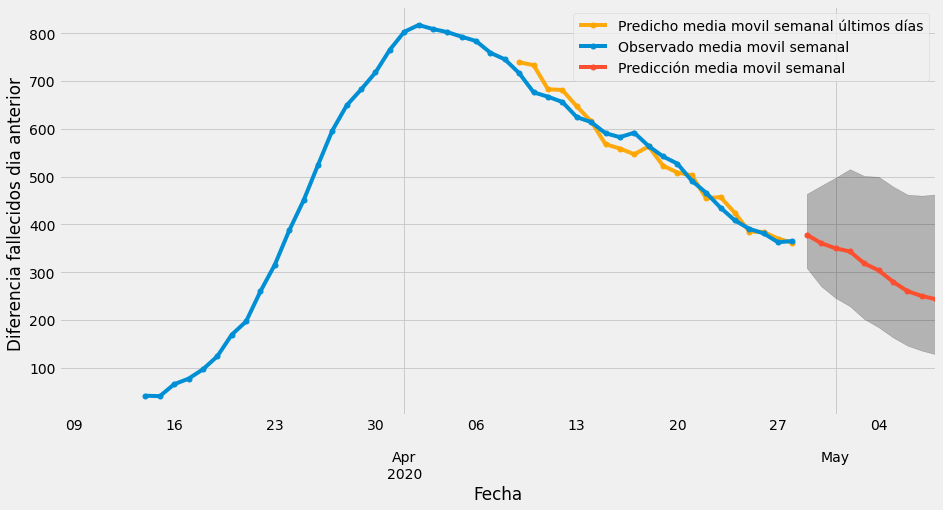

In [48]:
pred_uc_prev = results2.get_prediction(start=pd.to_datetime('2020-04-09 00:00:00'))

pred_uc_prev = math.e**pred_uc_prev.predicted_mean
print(pred_uc_prev)

ax = pred_uc_prev.plot( alpha=.95, figsize=(14, 7),color= "orange",
                       label='Predicho media movil semanal últimos días',marker='o', markersize=5)

pred_uc = results2.get_forecast(steps=10)

pred_ci = pred_uc.conf_int()
pred_ci = math.e**pred_ci
pred_uc = math.e**pred_uc.predicted_mean
ax = data_sem["Diferencia fallecidos dia anterior"].plot(label='Observado media movil semanal', figsize=(14, 7),marker='o', markersize=5)
pred_uc.plot(ax=ax, label='Predicción media movil semanal',marker='o', markersize=5)
print(pred_uc)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Fecha')
ax.set_ylabel('Diferencia fallecidos dia anterior ')
plt.legend()
plt.savefig(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\imagenes\predicción_media_movil.png');

plt.show()


In [43]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(np.log(data_es["Diferencia fallecidos dia anterior"]),order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
                        


ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:328.03184346907767
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:231.35368928810814
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:144.287130138717


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:968.3262220888821
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:150.06196761635766
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:144.67373158945605
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:38.38511618746105


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:991.2185139014153
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:266.9676451594046
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:179.2066603075794
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:112.89311443810988


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:781.0289555703049
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:129.37646738064524


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:121.0323603429137


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:15.606351410202333


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:779.815517094451
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:89.22029537131431
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:-28.12111910138085
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:78.59055782917136


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:839.9779039435373
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:-29.773088278849656
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:-26.31442157996642
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:-0.22637138829301495


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:1092.4255565458395
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:74.65744404501505
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:-27.831240424055892
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:64.43303180092694


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:1187.5327182475266
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:-27.79170034944299
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:-25.89480943427256
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:1.6240447430170075


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:1192.5605019984541
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:97.47082232501411


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:-27.531466188693805
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:82.49565288192217


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:1036.3998610144915
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:-27.805110264156475


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:-26.051336573311744
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:-2.516805783762729


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:1035.0645547684526
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:77.44056133474218


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:-23.500536563142358
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:57.82082202566239


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:1125.678349195972
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:-25.82183987158423
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:-13.954629705078649
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:-0.9114350520346015


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:1124.4587070855382
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:63.781210359509714
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:-26.17986782724124
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:58.1457849826474


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:1056.0891199687867
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:-26.093489930755496
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:-24.397407626831345
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:2.598354658013985


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:1061.2380391818936
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:65.0841583189301
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:-25.85065213747876
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:57.70069043996591


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:1138.76778891813
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:-27.96111210450404
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:-23.93288203345952
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:4.343540494197373
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:1143.7946333093696


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [44]:
mod = sm.tsa.statespace.SARIMAX(np.log(data_es["Diferencia fallecidos dia anterior"]),
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                       SARIMAX Results                                        
Dep. Variable:     Diferencia fallecidos dia anterior   No. Observations:                   52
Model:                SARIMAX(1, 1, 1)x(1, 1, [], 12)   Log Likelihood                   1.828
Date:                                Wed, 29 Apr 2020   AIC                              4.344
Time:                                        13:25:57   BIC                              9.376
Sample:                                    03-08-2020   HQIC                             5.793
                                         - 04-28-2020                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6861      0.162     -4.223      0.000      -1.004      -0.368
ma.

Fecha
2020-04-08    875.786922
2020-04-09    640.545845
2020-04-10    632.748960
2020-04-11    575.730511
2020-04-12    694.795495
2020-04-13    504.690312
2020-04-14    525.129521
2020-04-15    630.322254
2020-04-16    525.527150
2020-04-17    552.125681
2020-04-18    679.624206
2020-04-19    397.752620
2020-04-20    418.991425
2020-04-21    349.247128
2020-04-22    344.848786
2020-04-23    533.622084
2020-04-24    325.108739
2020-04-25    376.356797
2020-04-26    358.288542
2020-04-27    303.418036
2020-04-28    282.188537
Freq: D, dtype: float64
2020-04-29    454.353563
2020-04-30    318.914923
2020-05-01    315.727828
2020-05-02    336.404716
2020-05-03    344.221032
2020-05-04    347.581182
2020-05-05    289.402891
2020-05-06    297.844061
2020-05-07    226.511899
2020-05-08    259.579841
Freq: D, dtype: float64


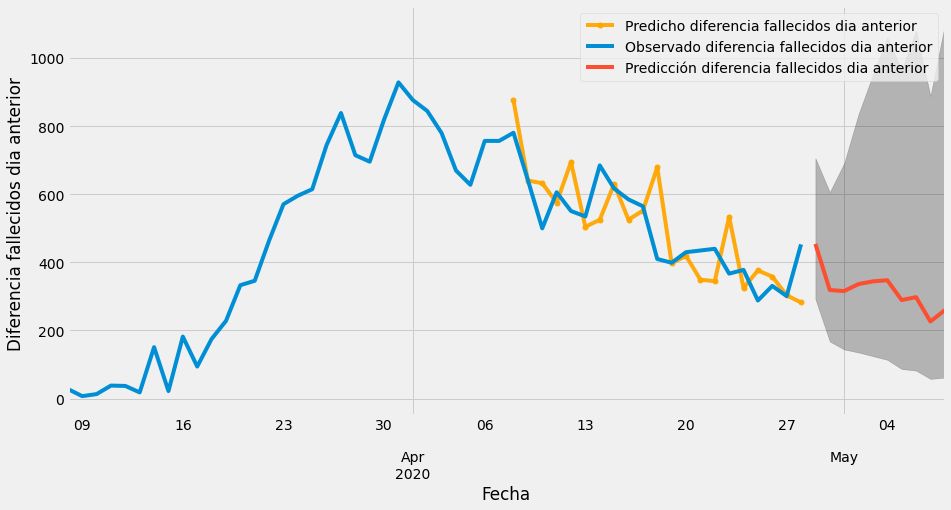

In [45]:
pred_uc_prev = results.get_prediction(start=pd.to_datetime('2020-04-08 00:00:00'))
pred_uc_prev = math.e**pred_uc_prev.predicted_mean

print(pred_uc_prev)

ax = pred_uc_prev.plot( alpha=.95, figsize=(14, 7),color= "orange",
                       label='Predicho diferencia fallecidos dia anterior',marker='o', markersize=5)

pred_uc = results2.get_forecast(steps=10)


pred_uc = results.get_forecast(steps=10)

pred_ci = pred_uc.conf_int()
pred_ci = math.e**pred_ci
pred_uc = math.e**pred_uc.predicted_mean
ax = data_es["Diferencia fallecidos dia anterior"].plot(label='Observado diferencia fallecidos dia anterior', figsize=(14, 7))
pred_uc.plot(ax=ax, label='Predicción diferencia fallecidos dia anterior')
print(pred_uc)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Fecha')
ax.set_ylabel('Diferencia fallecidos dia anterior ')
plt.savefig(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\imagenes\predicción.png')

plt.legend()
plt.show()

In [46]:
from statsmodels.formula.api import ols
data_mad= data_mad[data_mad["fecha_informe"] == data_mad["fecha_informe"].max()]
results = ols('tasa_incidencia_acumulada_total ~ data_mad["Renta Categorical"] ', data=data_mad).fit()
table = sm.stats.anova_lm(results)
table

,df,sum_sq,mean_sq,F,PR(>F)
"data_mad[""Renta Categorical""]",4.0,1.081020e+06,270255.058254,3.18459,0.016784
Residual,95.0,8.062020e+06,84863.367032,NaN,NaN


In [47]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                  
===========================================================================================
Dep. Variable:     tasa_incidencia_acumulada_total   R-squared:                       0.118
Model:                                         OLS   Adj. R-squared:                  0.081
Method:                              Least Squares   F-statistic:                     3.185
Date:                             Wed, 29 Apr 2020   Prob (F-statistic):             0.0168
Time:                                     13:25:58   Log-Likelihood:                -706.77
No. Observations:                              100   AIC:                             1424.
Df Residuals:                                   95   BIC:                             1437.
Df Model:                                        4                                         
Covariance Type:                         nonrobust                                         
======================================================================================================================
                                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
Intercept                                            872.5188     70.654     12.349      0.000     732.253    1012.784
data_mad["Renta Categorical"][T.Renta Baja]           95.2550    107.331      0.887      0.377    -117.824     308.334
data_mad["Renta Categorical"][T.Renta Media-Alta]   -162.9908    103.197     -1.579      0.118    -367.862      41.880
data_mad["Renta Categorical"][T.Renta Media-Baja]   -177.0810     90.195     -1.963      0.053    -356.140       1.978
data_mad["Renta Categorical"][T.Renta Media-Media]  -186.6428     89.570     -2.084      0.040    -364.462      -8.824
==============================================================================
Omnibus:                        3.134   Durbin-Watson:                   1.489
Prob(Omnibus):                  0.209   Jarque-Bera (JB):                3.005
Skew:                           0.421   Prob(JB):                        0.223
Kurtosis:                       2.889   Cond. No.                         6.39
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""